<a href="https://colab.research.google.com/github/allen44/endo-us-econ-analysis/blob/main/nlp_for_gdp_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
US GDP data is released every three months. Is it possible to forecast the next (in 0-3 months) GDP data release by using the data available from any source before then? Also interesting: is it possible to forecast the 2nd GDP release from today (3-6 months from now), or even the 3rd GDP release from today (6-9 months from now)?

Many types of economic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using a publically available source--the ISM Report on Business, which is released on the first business dfay of every month--this notebook will forecast the upcoming GDP release up to one quarter in the future.

# Background


## Research Review
The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In this paper, the authors evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the economic data releases to create new features to use as input to a model.

## Data Selection Criteria

There are over 700 thousand economic data series that a readily accessible from the St. Louis Fed's API, and ten's of thousands more from other government and private sources. 

For this notebook, I selected a handful of 'classically important' economic measures that economist's have used for decades in predicting business cycles and guiding national economic policy. This selection process has two primary benefits:
1. These data series have been vetted by practictioner's with domain expertise and the literature shows them to be useful in a variety of contexts.
2. These data series have histories that span to multiple decades before the rise of Big Data; some series start in the 1940s and earlier.


#### Numerical Data
Most of the numerical data are aggregated from direct measures of economic activity (such as dollar of goods sold, or number of building permits issued). Other numerical data are aggregations of surveys completed by participents in the economy (such as the PMI index, or the GDP Nowcast).

#### Textual Data
The textual data for this notebook is from the Institue for Supply Management's (ISM) Report on Business which is also the source of the some of the numerical data: PMI Index, and NMI Index. This report has been published on the first day of the month since the 1940's under a few different names--the most-used being the "PMI", or "Purchasing Managers Index". 

Confusingly, other research firms release data with the name "PMI", but this notebook will use the ISM's PMI report as it has the longest history.

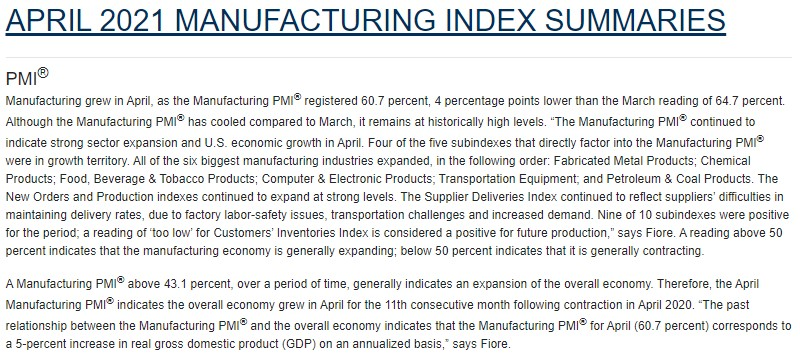


Along the numerical data in each report, the ISM summarizes the survey reponses in a few paragraphs at the beginning of the report, and for each subsection. Additionally, one sections include a selection of quotes from survey respondants. These quote's are often 'soundbite-like' and add sentiment to the report.

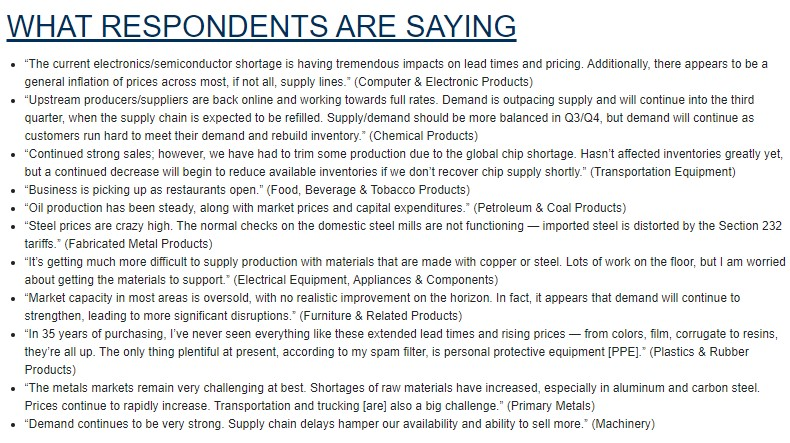



These textual summaries and quotes will be the input to the NLP model. 

## Todo List:
3. Perform baseline modelling to choose a set of models to tune further.
4. Write up 
  * Exploration - talk about the important features
  * 3 important one, 3 non important ones
  * bivariate chart showing relation between them
  * show distributions
  * EDA: group categories with high-ratio and low-ratio, instead of having hundreds of categories.
  * Wrangling- describe manipulation and data changes
  * Methods
  * Make a plot n_sample for training, as a function of performance on the validation (always use the same test set). Look for a convergence of the performance after reaching sufficne samples. Use the best hyperparameters, not a grid search. (Try decision tree first, because it's fast.
  * discussion on each model, with summary of advs and disadvs of each model, assumptions
  * Most important  is to describe shortcomings of the data and analysis-room for improvement. Weaknesses/ limitations in the model. Show readers where the model and analysis can be improved.
  * Explain the choices made in the analysis
  * statistical tests of significance
  * Show chart with final perf on test set


# Target

The sign of the change in the GDP growth--either positive, negative. As GDP growth is the change in GDP, the target is the sign of the change of the change in GDP. This can also be described as the sign of the 2nd-order rate of change, or the acceleration, of GDP.

By choosing the target this way, this frames the problem we are solving as a binary classification problem.

The image shows the change in GDP. The target variable, as depicted in the image, is the slope of the line.

For this notebook, we will assign a positive sign to any zero change.

As GDP is reported quarterly while the ISM reports are released monthly. As a first approach to the issue of the GDP frequency being one third of the ISM frequency, we will forward-fill the GDP data series.


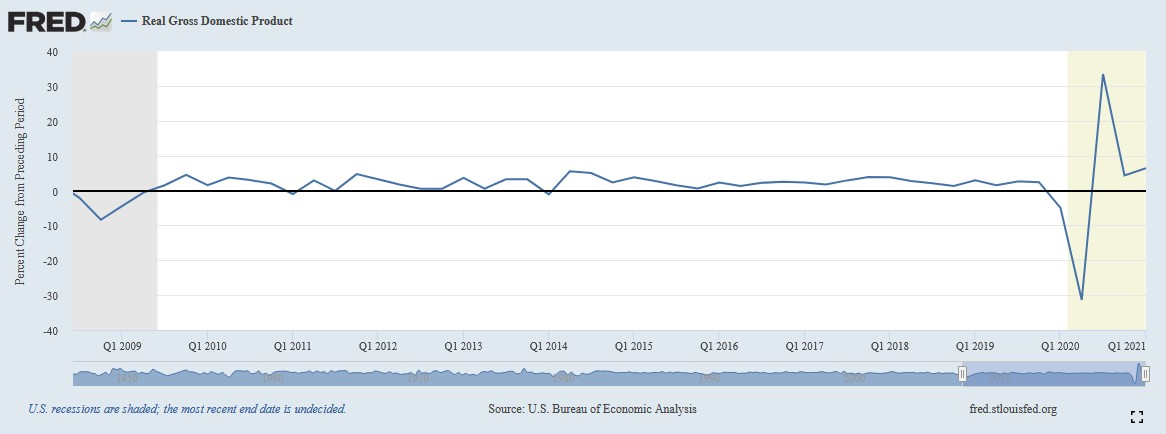

# Setup environment

### Mount the GDrive storage

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Clone the Github repository into GDrive

In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [3]:
# ! git clone https://github.com/allen44/endo-us-econ-analysis

In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis'

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [5]:
! ls

contractions.py		   models	      requirements.txt
data			   news_cache.sqlite  us_econ_analysis.sqlite
model_evaluation_utils.py  __pycache__


In [6]:
# If any modules are upgraded to a more recent version, restart runtime 
# to prevent errors
! pip install -r requirements.txt

In [7]:
# Set api key variables
% cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

# import config
# API_KEY = config.API_KEY

from pathlib import Path
import os
working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


## Import Modules

In [8]:
# install chromium, its driver, and selenium
! apt update
! apt install chromium-chromedriver

! python -m spacy download en_core_web_md
! python -m spacy validate

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad

In [9]:
import re
import pickle
import unicodedata
import requests
import os
import pickle

import requests_cache
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import spacy

# Load contraction map
from contractions import CONTRACTION_MAP

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm


from pprint import pprint

import stanza
stanza.download('en') 

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('conll2000')

pd.options.display.max_colwidth = 200
%matplotlib inline

import model_evaluation_utils as meu

2021-06-18 22:04:05 INFO: Downloading default packages for language: en (English)...
2021-06-18 22:04:09 INFO: File exists: /root/stanza_resources/en/default.zip.
2021-06-18 22:04:14 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


# Data Retrieval with Web Scraping

The archived text of the ISM releases are hard to get, while the numerical data are easy to find. For this data, we'll scrap the news releases from PR News Wire as the ISM releases after 2012 are still available there.

## Web scraping static content with Beautiful Soup and Requests

In [10]:
url_root = 'https://www.prnewswire.com/news/institute-for-supply-management'
urls = [ f'{url_root}/?page={p}&pagesize=100' \
        for p in (1, 2, 3, 4)]
session = requests_cache.CachedSession('news_cache')
headers = {'User-Agents': 'Mozilla/5.0',
           'referer': url_root}

# Identify links of interest
links = []
links_suffixes = []
for url in urls:
  # Use requests to retrieve data from a given URL
  news_response = session.get(url, headers=headers)
  # Parse the whole HTML page using BeautifulSoup
  news_soup = BeautifulSoup(news_response.text, 'html.parser')
  # Get a list of all the links
  for link in news_soup.find_all('a'):
    # print(link.get('href'))
    # print(type(link.get('href')))
    href = str(link.get('href'))
    if 'news-release' in href:
      # Filter the links to include the phrase 'PMI-at'
      if 'pmi-at' in href \
      and 'hospital' not in href \
      and 'services' not in href: 
        suffix = link.get('href').replace('/news-releases', '')
        links.append(f'{url_root}{suffix}')
        links_suffixes.append(suffix)
      # elif 'nmi-at' in str(link.get('href')):
      # links.append(link.get('href'))
direct_links = ['https://www.prnewswire.com/news-releases'+ suffix for suffix in links_suffixes ]
len(links), len(links_suffixes), len(direct_links)

(99, 99, 99)

In [11]:
links[:5]

['https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-7-april-2021-manufacturing-ism-report-on-business-301281490.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-64-7-march-2021-manufacturing-ism-report-on-business-301260206.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-8-february-2021-manufacturing-ism-report-on-business-301236952.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-58-7-january-2021-manufacturing-ism-report-on-business-301218544.html']

In [12]:
# for link in links[0:2]:
print(direct_links[0])
res = session.get(direct_links[0])
soup = BeautifulSoup(res.text, 'html.parser')


https://www.prnewswire.com/news-releases/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html


In [13]:
# Uncomment to view the html and the soup object

# soup

Lots of info is missing from the text here, while the missing text does show correctly in a web browser. It looks like the interesting content of this page is rendered in the javascript, so we'll need a tool suitable for scraping dyanmic web pages.

## Web scraping dynamic content with Selenium

In [14]:
# Uncomment to lead selenium and scrape the URLs

# from selenium.webdriver import ChromeOptions, Chrome
# # from selenium.webdriver.support import expected_conditions as EC
# # from selenium.webdriver.common.by import By
# # from selenium.webdriver.support.ui import WebDriverWait

# def start_new_driver():
#   # set options to be headless, ..
#   options = ChromeOptions()
#   options.add_argument('--headless')
#   options.add_argument('--no-sandbox')
#   options.add_argument('--disable-dev-shm-usage')
#   prefs = {
#       # Skip loading images
#       'profile.managed_default_content_settings.images':2,
#       # Use disk cache
#       "profile.managed_default_content_settings.images": 2,
#       'disk-cache-size': 4096
#       }
#   options.add_experimental_option("prefs", prefs)
#   # open it, go to a website, and get results
#   driver = Chrome(options=options)
#   return driver

# # Get page sources
# page_sources = []
# page_urls = []
# for direct_link in tqdm(direct_links, desc='direct_links'):
#     driver = start_new_driver()
#     driver.get(direct_link)
#     raw_page_source = driver.page_source
#     # Unicode-normalize the source
#     normalized_page_source = unicodedata.normalize('NFKD', raw_page_source)
#     page_sources.append(normalized_page_source)
#     page_urls.append(driver.current_url)
#     driver.close()

# # Save page sources
# page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
# with open(page_sources_path, 'wb') as f:
#   pickle.dump(page_sources, f)

# page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
# with open(page_urls_path, 'wb') as f:
#   pickle.dump(page_urls, f)

# len(page_sources), len(page_urls)

In [15]:
# Load page sources with this cell, or uncomment cell above to scrape fresh data (it's slow)
page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
with open(page_sources_path, 'rb') as f:
  page_sources = pickle.load(f)

page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
with open(page_sources_path, 'rb') as f:
  page_urls =  pickle.load(f)

len(page_sources), len(page_urls)

(99, 99)

In [16]:
normalized_page_sources = []
for raw_page_source in page_sources:
  normalized_page_sources.append(unicodedata.normalize('NFKD', raw_page_source))
page_sources = normalized_page_sources

# Assert that all urls and page_sources are unique
df = pd.DataFrame({'url': page_urls, 'page_source': page_sources})
assert df['url'].is_unique
assert df['page_source'].is_unique

len(page_sources)

99

## Parse the Release body

In [17]:
#Parse release_bodies from page source
releases = []
paragraphs_all_releases_soup = []
paragraphs_all_releases_text = []
for i, release_page_source in enumerate(page_sources):
  # print(release_page_source)
  release = {}
  soup = BeautifulSoup(release_page_source, 'html.parser')
  release['release_body'] = soup.find('section', 'release-body')
  paragraphs_this_release = release['release_body'].find_all('p')
  release['paragraphs'] =  paragraphs_this_release
  for paragraph in paragraphs_this_release:
    paragraphs_all_releases_soup.append(paragraph)
    paragraphs_all_releases_text.append(paragraph.text)
  # Select the first date in the release body
  date = release['release_body'].select('span.xn-chron')[1].text
  # print(date)
  # print(release['paragraphs'][0:5])
  release['date'] = date
  releases.append(release)
len(releases), len(paragraphs_all_releases_soup), len(paragraphs_all_releases_text)

(99, 62940, 62940)

#### Tests: Check the properties of the release bodies

In [18]:
# check to make sure the release bodies are unique
df = pd.DataFrame.from_dict(releases)
assert df['release_body'].is_unique
assert df['paragraphs'].apply(repr).is_unique

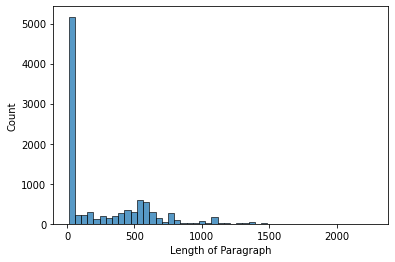

In [19]:
# Compare number of paragraphs in different releases to see if the number is constant,
# which would indicate a stable paragraph structure in the text
lengths = []
for paragraph_text in paragraphs_all_releases_text:
  # ignore paragraphs shorter than 10:
  if len(paragraph_text)>10:
    lengths.append(len(paragraph_text)) 
lengths_hist = sns.histplot(lengths)
lengths_hist.set(xlabel='Length of Paragraph');

No conclusion can be made with the paragraph structure alone. There are lots of zero-length paragraphs.

In [20]:
# check for paragraphs that are repeated accross multiple releases.
all_paragraphs_series = pd.Series(paragraphs_all_releases_text, name='paragraphs_all_releases_text')
all_paragraphs_series.is_unique

False

Some paragraphs  not unique. What are the most common paragraphs?


We see that there are non-unique paragraphs in the corpus. Which are they?

In [21]:
all_paragraphs_series.value_counts()

Index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  1092
Net                                                                                                                                                                                                                                                                                                                                                                                         

## Identify Relevant Paragraphs from Release Body


The paragraphs groups of interest are:
* Summary
* What Respondants are Saying 
* Commodities Up in Price 
* Commodities Down in Price 
* Commodities in Short Supply

Other paragraphs will not be included in this notebook.

All the PMI reports include the same paragraph groups, except for minor and infrequent changes to format, such as when the ISM changed the name of the report from PMI to Manufacturing PMI.

### Summary

In [22]:
# Parse from the top and group the text as the first group, summary. 
# Stop parsing upon encountering the string: 'WHAT RESPONDENTS ARE SAYING'

import dateutil.parser

def parse_summary(paragraphs: bs4.element.ResultSet):
  summary_paragraphs_by_release = []
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # fix unicode change to a common string, PMITM to PMI
    text = re.sub('( PMITM )|( PMI® )', ' PMI ', text)
    if not text:
      # Some paragraphs are exclusively whitespace, so exclude these
      continue
    elif re.match('.*DO NOT CONFUSE THIS NATIONAL REPORT.*', text):
      # Exclude this non-informative paragraph that only clarifies that this 
      # report is not the same  as another report
      continue
    elif re.match('^.+\/PRNewswire\/ -- ', text):
      # Remove this portion of paragraph, containing only the location, date and byline of the news outlet
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^.+\/PRNewswire\/ -- ', '', text))
    elif re.match('^The report was issued today by.*Survey Committee.\s', text):
      # Remove this portion of paragraph, containing only person presenting the report
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^The report was issued today by.*Survey Committee.\s', '', text))
    elif 'WHAT RESPONDENTS ARE SAYING' in text:
      #End of summary section; beginning of next section
      break
    else:
      summary_paragraphs_by_release.append(text)
  return summary_paragraphs_by_release

summary_paragraphs_by_release = [parse_summary(release['paragraphs']) for release in releases]
len(summary_paragraphs_by_release)

99

In [23]:
summary_paragraphs_by_release[0]

["New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Exports and Imports Growing",
 "Economic activity in the manufacturing sector grew in May, with the overall economy notching a 12th consecutive month of growth, say the nation's supply executives in the latest Manufacturing ISM® Report On Business®.",
 'The report was issued today by Timothy R. Fiore, CPSM, C.P.M., Chair of the Institute for Supply Management® (ISM®) Manufacturing Business Survey Committee:',
 '"The May Manufacturing PMI registered 61.2 percent, an increase of 0.5 percentage point from the April reading of 60.7 percent. This figure indicates expansion in the overall economy for the 12th month in a row after contraction in April 2020. The New Orders Index registered 67 percent, increasing 2.7 percentage points from the April reading of 64.3 percent. The Production Index registere

In [24]:
summary_paragraphs_flat_by_release = []
for summary_paragraphs in summary_paragraphs_by_release:
  summary_paragraphs_flat_by_release.append(' '.join(summary_paragraphs))

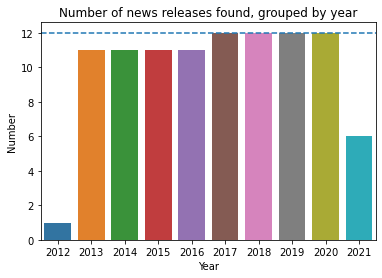

In [25]:
def parse_date(paragraphs: bs4.element.ResultSet):
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # Parse the date from this paragraph
    match = re.match('^.+\/PRNewswire\/ -- ', text)
    if match:
      # print(paragraph)
      date_string = paragraph.select('span.xn-chron')[0].text
      return pd.to_datetime(date_string)

# Parse dates
release_dates = [parse_date(release['paragraphs']) for release in releases]
dates_count = pd.Series(release_dates).dt.year.value_counts()

# Plot
ax = sns.barplot(x=dates_count.index,
            y=dates_count)
ax.axhline(12, linestyle='--')
ax.set(title='Number of news releases found, grouped by year',
       ylabel='Number',
       xlabel='Year')
plt.show()

We can see that there are some missing months. 

Except for starting year (2012) and the ending year (2021), we expect that there should be twelve releases per year. However, we see some years with only eleven releases.
These releases are missing from the news relese source, so there's no scraping techinique we could use to get that data from the same news site, unfortunately.

Missing years and month: 
* 2013: March,
* 2014: May, 
* 2015: August, 
* 2016: November

In [26]:
summary_paragraphs[0]

"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's supply executives in the latest Manufacturing ISM Report On Business®."

### What Respondants are Saying

This section contain quotes from the anonymous supply managers responding to the survey. These quotes may be cherry-picked by the decision makers who compile the report, but this section of the report is probably the most useful as an input into and NLP sentiment analysis model.

In [27]:
# abbreviation: wras = what_respondants_are_saying
def parse_wras(releases: list):
  wras_soups = []
  wras_texts = []
  wras_soups_flat = []
  wras_texts_flat = []
  for release in tqdm(releases):
    wras_soup = release['release_body'].find_all('li')
    wras_soups.append(wras_soup)

    wras_text = [unicodedata.normalize('NFKD', tag.text.strip()) for tag in wras_soup]
    wras_texts.append(wras_text)
    
    for tag in wras_soup:
      wras_soups_flat.append(tag)
    for text in wras_text:
      wras_texts_flat.append(text)
  assert len(wras_soups)==len(wras_texts)
  assert len(wras_soups_flat)==len(wras_texts_flat)
  return (wras_soups,  # List of lists of soups
          wras_texts,    # List of lists of texts
          wras_soups_flat, # lists of soups
          wras_texts_flat) # lists of texts

(wras_soups,
  wras_texts,  
  wras_soups_flat,
  wras_texts_flat) = parse_wras(releases)  

len(wras_soups), len(wras_texts), len(wras_soups_flat), len(wras_texts_flat)

  0%|          | 0/99 [00:00<?, ?it/s]

(99, 99, 998, 998)

In [28]:
wras_texts[:1]

[['"Supplier performance — deliveries, quality, it\'s all suffering. Demand is high, and we are struggling to find employees to help us keep up." [Computer & Electronic Products]',
  '"Changes in currency exchange rates favorably contributed to our quarterly performance. Continued strong consumer demand for our high-quality products also provided increased sales." [Chemical Products]',
  '"Ongoing component shortages are driving dual sourcing and longer-term supply plans to be implemented." [Transportation Equipment]',
  '"Difficulty finding workers at the factory and warehouse level is not only impacting our production, but suppliers\' as well: Spot shortages and delays are common due to an inability to staff lines. Delays at the port continue to strain inventory levels." [Food, Beverage & Tobacco Products]',
  '"[A] lack of qualified candidates to fill both open office and shop positions is having a negative impact on production throughput. Challenges mounting for meeting delivery da

#### Parse WRAS quote and industry

In [29]:
wras_tuples_by_release = []
wras_tuples_flat = []
for quote_and_ind_str_list in wras_texts:
  inner_wras_tuples = []
  for quote_and_ind_str in quote_and_ind_str_list:
    match_0 = re.match('\"?(.+)\"?\s\((.*)\)', quote_and_ind_str)
    match_1 = re.match('"(.*")\s+[/(/[]([A-Z].*)[\]\)]', quote_and_ind_str)
    if match_0:
      # print(match_0)
      # print(match_0.group(1)[:20], match_0.group(2))
      inner_wras_tuples.append((match_0.group(1), match_0.group(2)))
      wras_tuples_flat.append((match_0.group(1), match_0.group(2)))
    elif match_1:
      # print(match_1)
      # print(match_1.group(1)[:20], match_1.group(2))
      inner_wras_tuples.append((match_1.group(1), match_1.group(2)))
      wras_tuples_flat.append((match_1.group(1), match_1.group(2)))
    else:
      # Too few to matter (<4), ignore precessing these outliers; just append as-is
      # print(quote_and_ind_str)
      continue
  wras_tuples_by_release.append(inner_wras_tuples)

len(wras_tuples_by_release), len(wras_tuples_flat)

(99, 997)

In [30]:
wras_tuples_by_release[:1]

[[('Supplier performance — deliveries, quality, it\'s all suffering. Demand is high, and we are struggling to find employees to help us keep up."',
   'Computer & Electronic Products'),
  ('Changes in currency exchange rates favorably contributed to our quarterly performance. Continued strong consumer demand for our high-quality products also provided increased sales."',
   'Chemical Products'),
  ('Ongoing component shortages are driving dual sourcing and longer-term supply plans to be implemented."',
   'Transportation Equipment'),
  ('Difficulty finding workers at the factory and warehouse level is not only impacting our production, but suppliers\' as well: Spot shortages and delays are common due to an inability to staff lines. Delays at the port continue to strain inventory levels."',
   'Food, Beverage & Tobacco Products'),
  ('[A] lack of qualified candidates to fill both open office and shop positions is having a negative impact on production throughput. Challenges mounting for

In [31]:
wras_texts_by_release = []
wras_texts_flat_by_release = []
wras_industries_by_release = []
wras_industries_flat_by_release = []
for wras_tuples in wras_tuples_by_release:
  wras_text, wras_industries = zip(*wras_tuples)
  wras_text_flat = ' '.join(wras_text)
  wras_industries_flat = ' '.join(wras_industries)

  wras_texts_by_release.append(wras_text)
  wras_texts_flat_by_release.append(wras_text_flat)
  wras_industries_by_release.append(wras_industries)
  wras_industries_flat_by_release.append(wras_industries_flat)

### Commodities Up, Down, and in short supply

This section is not likely to be useful for a sentiment analysis. But, this does appear to be a useful source of categorical data that could later be transformed into usefuls numerical series as an input to any model.

One possible modelling application would be to test a hypothesis that the data in this section is a leading indicator of commodity prices.

#### Parse commodites up/down in price and short supply from Paragraphs

In [32]:
comm_up_lists = []
comm_down_lists = []
comm_short_lists = []
comm_up_lists_flat = []
comm_down_lists_flat = []
comm_short_lists_flat = []
for i, release in enumerate(releases):
  # Up
  comm_up_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').get_text().replace('Commodities Up in Price', '').strip())
  if not comm_up_inter_str:
    # print('if up_4')
    comm_up_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  
  if re.match('The only commodity listed up in price.+is\s',comm_up_inter_str):
    # print('up_match_1')
    comm_up_str = re.sub('The only commodity listed up in price.+is\s', '', comm_up_inter_str)
  else:
    comm_up_str = comm_up_inter_str
  
  if re.search('Commodities', comm_up_str):
    comm_up_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('span').get_text().replace('Commodities Up in Price', '').strip()
  
  # Source forgot a semi-colon one time
  if comm_up_inter_str == 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2) and Steel Products* (10).':
    comm_up_str = 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2); and Steel Products* (10).'
  
  assert comm_up_str
  assert not re.search('Commodities', comm_up_str)
  # print(i, '\t', comm_up_str)

  # Down
  comm_down_heading_text = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice'))
  if comm_down_heading_text:
    if 'Up' in comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip():
      # print('if Up')
      comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent().find_parent().get_text()
    else:
      comm_down_inter_str = comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if down_4')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  else:
    # print('if 2')
    comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if 3')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.next_sibling.get_text()
  assert comm_down_str
  assert not re.search('Commodities', comm_down_str)
  # print(i, '\t', comm_down_str) 

  # Short
  comm_short_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('p').get_text().replace('Commodities in Short Supply', '').strip())
  if re.match('[Nn]o\scommodities\s.*\sshort\ssupply',comm_short_inter_str):
    # print(i, 'short_match_1')
    comm_short_str = re.sub('.*[Nn]o\scommodities\s.*\sshort\ssupply.*', 'None.', comm_short_inter_str)
  elif re.match('.*\sis\sthe\sonly\scommodity.*',comm_short_inter_str):
    # print(i, 'short_match_2')
    comm_short_str = re.sub('\sis\sthe\sonly\scommodity.*', '', comm_short_inter_str)
  elif re.match('.*no commodities listed in short supply.*', comm_short_inter_str):
    # print(i, 'short_match_3')
    comm_short_str = re.sub('^.*no commodities listed in short supply.*', 'None.', comm_short_inter_str)
  elif re.match('The only commodity.*short supply.*is\s', comm_short_inter_str):
    # print(i, 'short_match_4')
    comm_short_str = re.sub('The only commodity.*short supply.*is\s', '', comm_short_inter_str)
  elif re.match('Commodities\s.*in', comm_short_inter_str):
    # print(i, 'short_match_5')
    comm_short_str = release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('span').get_text().replace('Commodities in Short Supply ', '').strip()
  else:
    comm_short_str = comm_short_inter_str
  assert comm_short_str
  assert not re.search('Commodities', comm_short_str)

  # if re.match('Commodities\s.*in', comm_short_str):
  #   print(i, comm_short_str)
  #   raise
  # print(i, '\t', comm_short_str)
  # print(comm_short_str)
  
  # Remove any final '.'
  comm_up_list = re.sub('\.$', '', comm_up_str)
  comm_down_list = re.sub('\.$', '', comm_down_str)
  comm_short_list = re.sub('\.$', '', comm_short_str)

  # Split string into list at ';'
  comm_up_list = comm_up_str.split('; ')
  comm_down_list = comm_down_str.split('; ')
  comm_short_list = comm_short_str.split('; ')

  # # strip white space
  comm_up_list = [ele.strip() for ele in comm_up_list]
  comm_down_list = [ele.strip() for ele in comm_down_list]
  comm_short_list = [ele.strip() for ele in comm_short_list]

  # Append to list
  comm_up_lists.append(comm_up_list)
  comm_down_lists.append(comm_down_list)
  comm_short_lists.append(comm_short_list)

  for ele in comm_up_list:
    comm_up_lists_flat.append(ele)
  for ele in comm_down_list:
    comm_down_lists_flat.append(ele)
  for ele in comm_short_list:
    comm_short_lists_flat.append(ele)


In [33]:
# Check lengths
len(comm_up_lists), len(comm_down_lists), len(comm_short_lists)

(99, 99, 99)

In [34]:
# Check lengths
len(comm_up_lists_flat), len(comm_down_lists_flat), len(comm_short_lists_flat)

(1342, 575, 422)

#### Parse commodities and months Up/Down/Short-supply from "Commodites Up/Down in Price and Short Supply"

In [35]:
def parse_commodities_up_down_short_string(commodity_str, debug=False):
  # Remove unicode and Replace *
  commodity_str = unicodedata.normalize('NFKD', commodity_str).replace('*', '')

  # Check for 'None'
  match_none_no_digits = re.match('^None.$', commodity_str)
  match_none_digits = re.match('^None\s\((\d+)\)\.$', commodity_str)

  # Check for 'no commoditites are...'
  match_no_commod_no_digits = re.match('No commodities are', commodity_str)
  match_no_commod_digits = re.match('No commodities are.* \((\d+)\)', commodity_str)
  # Check for 'only commodity...'
  match_only_commodity_digits = re.match('(.+) \((\d+)\) is the only commodity.*', commodity_str)
  match_only_commodity_no_digits = re.match('([A-Z0-9#].*) is the only commodity.+\.', commodity_str)
  
  if match_none_no_digits or match_no_commod_no_digits:
    commod_str = 'None'
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_none_no_digits or match_no_commod_no_digits')
      print(commodity_str)
      print(tup)
  elif match_none_digits:
    commod_str = 'None'
    digits = int(match_none_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_none_digits')
      print(commodity_str)
      print(tup)
  elif match_no_commod_digits:
    commod_str = 'None'
    digits = int(match_no_commod_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_no_commod')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_no_digits:
    commod_str = match_only_commodity_no_digits.group(1)
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_digits:
    commod_str = match_only_commodity_digits.group(1)
    digits = match_only_commodity_digits.group(2)
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  else:
    # Check for 'and...commod_str..(digits)
    match_2 = re.match('^and\s([A-Z#\d].*)\s\((\d+)\)', commodity_str) # and..., with no period at end
    match_3 = re.match('^and\s(.*)', commodity_str)
    if match_2:
      commod_str = match_2.group(1)
      digits = int(match_2.group(2))
      tup = (commod_str, digits)
      if debug:
        print('match_2')
        print(commodity_str)
        print(i, match_2.groups())
        print(tup)
    elif match_3:
      commod_str = re.sub('\.$', '', match_3.group(1))
      digits = 1
      tup = (commod_str, digits)
      if debug:
        print('match_3')
        print(commodity_str)
        print(i, match_3.groups())
        print(tup)
    else:
      # Check for 'comod_str...(digits)
      match_4 = re.match('^([A-Z0-9#].*)\s\((\d+)\)$', commodity_str)
      match_5 = re.match('^([A-Z0-9#].*)', commodity_str)
      if match_4:
        commod_str = match_4.group(1)
        digits = int(match_4.group(2))
        tup = (commod_str, digits)
        if debug:
          print('match_4')
          print(commodity_str)
          print(i, match_4.groups())
          print(tup)
      elif  match_5:
        commod_str = match_5.group(1)
        digits = 1
        tup = (commod_str, digits)
        if debug:
          print('match_5')
          print(commodity_str)
          print(i, match_5.groups())
          print(tup)
      else:
        # If it doesn't match any ohter regular expression
        print(i, commodity_str)
        raise Error
  return tup

In [36]:
commodities_up_by_release = []
for comm_up_list in comm_up_lists:
  this_release = []
  for commod_up in comm_up_list:
    this_release.append(parse_commodities_up_down_short_string(commod_up))
  commodities_up_by_release.append(this_release)

commodities_down_by_release = []
for comm_down_list in comm_down_lists:
  this_release = []
  for commod_down in comm_down_list:
    this_release.append(parse_commodities_up_down_short_string(commod_down))
  commodities_down_by_release.append(this_release)

commodities_short_by_release = []
for comm_short_list in comm_short_lists:
  this_release = []
  for commod_short in comm_short_list:
    this_release.append(parse_commodities_up_down_short_string(commod_short))
  commodities_short_by_release.append(this_release)

In [37]:
len(commodities_up_by_release), len(commodities_down_by_release), len(commodities_short_by_release)

(99, 99, 99)

In [38]:
commodities_names_up_by_release = []
commodities_names_up_flat_by_release = []
for tup in commodities_up_by_release:
  commodities_names_up, _ = zip(*tup)
  commodities_names_up_by_release.append(commodities_names_up)
  commodities_names_up_flat_by_release.append(', '.join(commodities_names_up))

commodities_names_down_by_release = []
commodities_names_down_flat_by_release = []
for tup in commodities_down_by_release:
  commodities_names_down, _ = zip(*tup)
  commodities_names_down_by_release.append(commodities_names_down)
  commodities_names_down_flat_by_release.append(', '.join(commodities_names_down))

commodities_names_short_by_release = []
commodities_names_short_flat_by_release = []
for tup in commodities_short_by_release:
  commodities_names_short, _ = zip(*tup)
  commodities_names_short_by_release.append(commodities_names_up)
  commodities_names_short_flat_by_release.append(', '.join(commodities_names_short))

##### Check Outputs

In [39]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_names_up_by_release)):
#   print(f'{i},\t{comm_up_lists[i][0]},\t{commodities_up_by_release[i][0]}')

In [40]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_down_by_release)):
#   print(f'{i},\t{comm_down_lists[i][0]},\t{commodities_down_by_release[i][0]}')

In [41]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_short_by_release)):
#   print(f'{i},\t{comm_short_lists[i][0]},\t{commodities_short_by_release[i][0]}')

## Variables for further use:

`summary_paragraphs`,
`wras_tuples`,
`commodities_up`,
`commodities_down`,
`commodities_short`,

### Check the variables

In [42]:
# summary_paragraphs[0]

In [43]:
# wras_texts_flat_by_release[2]

In [44]:
# commodities_up_by_release[0]

In [45]:
# commodities_down_by_release[0]

In [46]:
# commodities_short_by_release[0]

## Make dataframes from parsed variables

In [47]:
dates_ser = pd.Series(release_dates, name='date')

summary_ser = pd.Series( summary_paragraphs_flat_by_release, 
                        name='summary')

wras_text_ser = pd.Series(wras_texts_flat_by_release, name='wras')

commodities_up_ser = pd.Series(commodities_names_up_flat_by_release, name='commodities_up_in_price')
commodities_up_count_ser = pd.Series([len(commodities_up) for commodities_up in commodities_up_by_release], 
                                     name='commodities_up_count')

commodities_down_ser = pd.Series(commodities_names_down_flat_by_release, name='commodities_down_in_price')
commodities_down_count_ser = pd.Series([len(commodities_down) for commodities_down in commodities_down_by_release], 
                                       name='commodities_down_count')

commodities_short_ser = pd.Series(commodities_names_short_flat_by_release, name='commodities_in_short_supply')
commodities_short_count_ser = pd.Series([len(commodities_short) for commodities_short in commodities_short_by_release], 
                                        name='commodities_short_count')

df = pd.DataFrame(data=[dates_ser,
                        summary_ser,
                        wras_text_ser,
                        commodities_up_ser,
                        commodities_up_count_ser,
                        commodities_down_ser,
                        commodities_down_count_ser,
                        commodities_short_ser,
                        commodities_short_count_ser]).T
df['date'] = pd.to_datetime(df['date'])
df['summary'] = df['summary'].astype('string')
df['wras'] = df['wras'].astype('string')
df['commodities_up_count'] = df['commodities_up_count'].astype(int)
df['commodities_down_count'] = df['commodities_down_count'].astype(int)
df['commodities_short_count'] = df['commodities_short_count'].astype(int)
df = df.set_index('date').sort_index()

##Get the target variable

In [48]:
# Set api key variables
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY

import pandas_datareader as pdr
import datetime
import requests_cache

# Get data from FRED
expire_after = datetime.timedelta(days=7)
session = requests_cache.CachedSession(cache_name='us_econ_analysis', expire_after=expire_after)
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime.today()

params = {
    'api_key': API_KEY['fred']
                }
gdp_growth = pdr.fred.FredReader('A191RP1Q027SBEA', 
                          start, end, 
                          session=session).read().squeeze().rename('gdp_growth')
gdp_growth.index = gdp_growth.index.rename('date')

# Get the sign of the change in gdp growth
# Make the  value 0 if sign is negative, or else 1.
gdp_growth_direction = (gdp_growth.diff()
                                  .dropna()
                                  .apply(np.sign)
                                  .map({-1:0, 0:1, 1:1,})
                                  .astype(np.int8)
                                  .rename('gdp_growth_direction')
                                  .resample('D').ffill())
# Add the target to the dataframe
df = df.join(gdp_growth_direction)

# Check the dataframe
df.sample(5)

,summary,wras,commodities_up_in_price,commodities_up_count,commodities_down_in_price,commodities_down_count,commodities_in_short_supply,commodities_short_count,gdp_growth_direction
date,,,,,,,,,
2019-08-01,"New Orders, Production, and Employment Growing Supplier Deliveries Slowing at a Faster Rate; Backlog Contracting Raw Materials Inventories Contracting; Customers' Inventories Too Low Prices Decrea...","General business trends are continuing to show signs of weakness resulting from tariffs and cost impacts of importing and exporting."" Business is strong mostly due to seasonality. Tariffs surcharg...","Corn, Steel Products",2,"Aluminum, Aluminum Products, Copper, Corrugated Boxes, Electrical Components, Polypropylene, Steel, Steel — Hot Rolled, Steel — Scrap, Steel — Stainless, Steel Products",11,"Electrical Components, Helium",2,0.0
2018-06-01,"New Orders, Production, and Employment Growing Supplier Deliveries Slowing at Faster Rate; Backlog Growing Raw Materials Inventories Growing; Customers' Inventories Too Low Prices Increasing at Fa...","We are currently overselling our forecast and don't see an end to the upswing in business. We are very concerned, however, about the tariffs proposed in Section 301 and are focusing on alternative...","Aluminum, Aluminum Based Products, Brass, Capacitors, Caustic Soda, Cobalt, Copper, Corrugate, Corrugated Boxes, Corrugated Cartons, Electrical Components, Freight, Paper, Resistors, Steel — Galva...",22,None,1,"Aluminum, Capacitors, Electrical Components, Electronic Components, Freight, Memory, Resistors, Steel Based Products, Steel – Hot Rolled",9,1.0
2016-06-01,"Economic activity in the manufacturing sector expanded in May for the third consecutive month, while the overall economy grew for the 84th consecutive month, say the nation's supply executives in ...","Business conditions remain strong with the exception of South America. Continued expectation for a strong year even with the headwinds of currency and economic slowdown."" Consistent sales growth i...","Aluminum, #1 Bundle Scrap, Copper, Corn, Crude Oil, Diesel, Electric Components, Gasoline, HDPE Resin, Oil, Petroleum Based Products, Polypropylene, Silver, Stainless Steel, Steel, Steel — Cold Ro...",18,Corrugated Boxes.,1,None,1,1.0
2015-02-02,This report reflects the recently completed annual adjustments to the seasonal adjustment factors used to calculate the indexes. Economic activity in the manufacturing sector expanded in January f...,"Strong customer demand for our products continues to grow."" Customers are presenting many new opportunities."" Consumer demand remains strong for automotive. Seeking alternatives to maximize produc...","Corn Based Products, Electric Components",2,"Aluminum, Brass, Butter, Carbon Steel, Copper, Copper Based Products, Diesel, Ethylene, Fuel Oil, Gasoline, HDPE Resin, Natural Gas, Nickel, Oil, Oil Based Products, PET Resin, Plastic Resin, Poly...",23,None,1,1.0
2016-05-02,"Economic activity in the manufacturing sector expanded in April for the second consecutive month, while the overall economy grew for the 83rd consecutive month, say the nation's supply executives ...","We are still running at capacity. New CapEx for $30 million to increase capacity, but will not be online until 2017."" Remaining a bit sluggish overall although showing signs of a pickup in some ar...","Aluminum, Aluminum Products, #1 Bundle Scrap, Carbon Steel Coil, Copper, Diesel, Ethylene, HDPE Resin, Oil, Palm Oil, Plastic Resins, Polypropylene, Propylene, Scrap Steel, Stainless Steel, Steel,...",19,Copper.,1,None,1,1.0


### Visualize the target variable

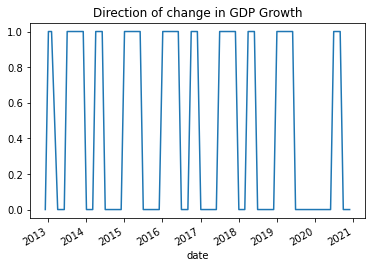

In [49]:
df['gdp_growth_direction'].plot()
plt.title('Direction of change in GDP Growth');

The target variable looks stationary. 

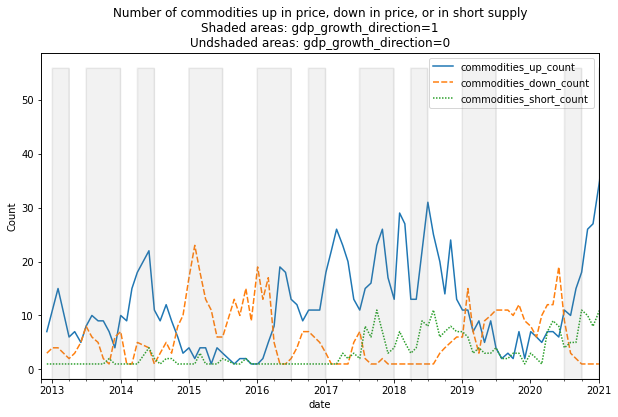

In [50]:
# Visualize the relationship between the numerical features and target
fig, ax1 = plt.subplots(figsize=(10,6)) # initializes figure and plots
ax2 = ax1.twinx()

g = sns.lineplot(data=df.drop(columns=['gdp_growth_direction']), ax=ax1)
g.set(ylabel='Count',
      title='Number of commodities up in price, down in price, or in short supply\nShaded areas: gdp_growth_direction=1\nUndshaded areas: gdp_growth_direction=0');

gdp_growth_direction['2012-11':].plot.area(ax=ax2, alpha=0.1, color='grey')
plt.yticks([]) # hide yticks of second axis
plt.show()

We don't see an obvious relationship between the target variable and the numerical features.

We can see from the plot that, recently, more commodities are up in price than at any other time since 2012, and more commodities are in short supply than at any other time since 2012.

# Processing & Understanding Text

## Define text processing functions

In [51]:
nlp = spacy.load('en_core_web_md')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [52]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

Remove accented characters

In [53]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

Expand Contractions

In [54]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

Remove special characters

In [55]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

Text stemming

In [56]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

Text lemmatization

In [57]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'my system keep crash ! his crash yesterday , ours crash daily'

Remove stopwords

In [58]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

Build a text normalizer

In [59]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_stemming=False, text_lemmatization=True, 
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True, stopwords=stopword_list):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize release text

In [60]:
df['clean_summary'] = normalize_corpus(df['summary'])
norm_corpus_summary = list(df['clean_summary'])

df[['summary','clean_summary']].tail()

,summary,clean_summary
date,,
2021-02-01,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Expo...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase export import grow report reflect recently comp...
2021-03-01,"New Orders, Production & Employment Growing Supplier Deliveries Slowing at Faster Rate; Backlog Growing Raw Materials Inventories Contracting; Customers' Inventories Too Low Prices Increasing; Exp...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory contracting customer inventory low price increase export import grow economic activity man...
2021-04-01,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Expo...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase export import grow economic activity manufactur...
2021-05-03,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices Increasing; ...",new order production employment grow supplier delivery slow slow rate backlog grow raw material inventory contracting customer inventory low price increase export import grow economic activity man...
2021-06-01,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Expo...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase export import grow economic activity manufactur...


In [61]:
df['clean_wras'] = normalize_corpus(df['wras'])
norm_corpus_wras = list(df['clean_wras'])

df[['wras','clean_wras']].tail()

,wras,clean_wras
date,,
2021-02-01,"Supplier factory capacity is well utilized. Increased demand, labor constraints and upstream supply delays are pushing lead times. This is more prevalent with international than U.S.-based supplie...",supplier factory capacity well utilize increase demand labor constraint upstream supply delay push lead time prevalent international u based supplier business remain strong manufacture run full ca...
2021-03-01,The coronavirus [COVID-19] pandemic is affecting us in terms of getting material to build from local and our overseas third- and fourth-tier suppliers. Suppliers are complaining of [a lack of] ava...,coronavirus [ covid ] pandemic affect term get material build local overseas third fourth tier supplier supplier complain [ lack ] available resource [ people ] manufacturing create major delivery...
2021-04-01,Late-winter storms in unexpected [areas] of the U.S. had our organization exercising business-continuity plans on a much more aggressive scale than anticipated. While the storms slowed our supply ...,late winter storm unexpected [ area ] u organization exercise business continuity plan much aggressive scale anticipate storm slow supply chain could meet order even though short feel come month a...
2021-05-03,"The current electronics/semiconductor shortage is having tremendous impacts on lead times and pricing. Additionally, there appears to be a general inflation of prices across most, if not all, supp...",current electronic semiconductor shortage tremendous impact lead time pricing additionally appear general inflation price across not supply line upstream producer supplier back online work towards...
2021-06-01,"Supplier performance — deliveries, quality, it's all suffering. Demand is high, and we are struggling to find employees to help us keep up."" Changes in currency exchange rates favorably contribute...",supplier performance delivery quality suffer demand high struggle find employee help keep change currency exchange rate favorably contribute quarterly performance continue strong consumer demand h...


## Save the dataframe

In [62]:
df.to_pickle(working_path/'data/intermediate/clean_df.pkl')

In [63]:
df = pd.read_pickle(working_path/'data/intermediate/clean_df.pkl')
summary_df = df[['summary','clean_summary']]
wras_df = df[['wras', 'clean_wras']]

# Understanding Language Syntax and Structure

Knowledge about the structure and syntax of language is helpful for further operations we will consider several approaches and later choose the approach that best models the data.

* Parts of Speech (POS) Tagging
* Shallow Parsing or Chunking
* Constituency Parsing
* Dependency Parsing

In [64]:
# Use a less normalized corpus for this section
summary_corpus = normalize_corpus(summary_df['summary'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)
wras_corpus = normalize_corpus(wras_df['wras'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# Choose a sample sentence
summary_sentence = str(summary_df.iloc[1]['summary'])
wras_sentence = str(wras_df.iloc[1]['wras'])

### Tagging Parts of Speech

The are several implementations available for tagging parts of speech. In this notebook, we'll try NLTK and spacy.

#### Using NLTK

In [65]:
def tag_pos_nltk(sentence:str):
  nltk_pos_tagged = nltk.pos_tag(sentence.split())
  return nltk_pos_tagged

##### Summary

In [66]:
summary_nltk_pos_tagged = tag_pos_nltk(summary_sentence)
pd.DataFrame(summary_nltk_pos_tagged, columns=['Word', 'POS tag']).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303
Word,Economic,activity,in,the,manufacturing,sector,expanded,in,"December,",following,one,month,of,"contraction,",and,the,overall,economy,grew,for,the,43rd,consecutive,"month,",say,the,nation's,supply,executives,in,the,latest,Manufacturing,ISM,Report,On,Business®.,"""The",PMI,registered,...,nine,industries,reporting,contraction,in,December,—,listed,in,order,—,are:,Nonmetallic,Mineral,Products;,Chemical,Products;,Miscellaneous,Manufacturing;,Plastics,&,Rubber,Products;,Fabricated,Metal,Products;,Transportation,Equipment;,Machinery;,Electrical,"Equipment,",Appliances,&,Components;,and,"Apparel,",Leather,&,Allied,Products.
POS tag,JJ,NN,IN,DT,NN,NN,VBD,IN,NNP,VBG,CD,NN,IN,NN,CC,DT,JJ,NN,VBD,IN,DT,CD,JJ,NNS,VBP,DT,JJ,NN,NNS,IN,DT,JJS,NN,NNP,NNP,IN,NNP,NNP,NNP,VBD,...,CD,NNS,VBG,NN,IN,NNP,NNP,VBN,IN,NN,NNP,VBZ,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,CC,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,CC,NNP,CC,NNP,NNP,CC,NNP,NNP


##### WRAS

In [67]:
wras_nltk_pos_tagged = tag_pos_nltk(wras_sentence)
pd.DataFrame(wras_nltk_pos_tagged, columns=['Word', 'POS tag']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178
Word,Many,Chinese,sources,are,coming,to,us,with,cost,reductions,to,maintain,their,current,business,"volumes.""",Saw,some,stronger,than,expected,demand,in,October,and,"November,",but,December,demand,is,weak,"comparatively.""",We,are,seeing,stabilization,of,orders,and,costs,...,production,has,leveled,off,from,their,previous,reduction,last,"month.""",Business,is,"strengthening.""",Prices,and,orders,are,staying,stronger,than,normal,for,December,—,a,pleasant,"surprise.""",Uncertainty,in,additional,government,regulations,and,tax,climate,seems,to,be,slowing,"orders."""
POS tag,JJ,JJ,NNS,VBP,VBG,TO,PRP,IN,NN,NNS,TO,VB,PRP$,JJ,NN,NN,NNP,DT,JJR,IN,VBN,NN,IN,NNP,CC,NNP,CC,NNP,NN,VBZ,JJ,NN,PRP,VBP,VBG,NN,IN,NNS,CC,NNS,...,NN,VBZ,VBN,RP,IN,PRP$,JJ,NN,JJ,NN,NNP,VBZ,JJ,NNS,CC,NNS,VBP,VBG,JJR,IN,JJ,IN,NNP,NNP,DT,JJ,NN,NNP,IN,JJ,NN,NNS,CC,NN,NN,VBZ,TO,VB,VBG,JJ


#### Using Spacy

In [68]:
def tag_pos_spacy(sentence:str):
  sentence_nlp = nlp(sentence)
  spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
  return pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']).T

##### Summary

In [69]:
tag_pos_spacy(summary_sentence)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357
Word,Economic,activity,in,the,manufacturing,sector,expanded,in,December,",",following,one,month,of,contraction,",",and,the,overall,economy,grew,for,the,43rd,consecutive,month,",",say,the,nation,'s,supply,executives,in,the,latest,Manufacturing,ISM,Report,On,...,:,Nonmetallic,Mineral,Products,;,Chemical,Products,;,Miscellaneous,Manufacturing,;,Plastics,&,Rubber,Products,;,Fabricated,Metal,Products,;,Transportation,Equipment,;,Machinery,;,Electrical,Equipment,",",Appliances,&,Components,;,and,Apparel,",",Leather,&,Allied,Products,.
POS tag,JJ,NN,IN,DT,NN,NN,VBN,IN,NNP,",",VBG,CD,NN,IN,NN,",",CC,DT,JJ,NN,VBD,IN,DT,JJ,JJ,NN,",",VBP,DT,NN,POS,NN,NNS,IN,DT,JJS,NNP,NNP,NNP,IN,...,:,NNP,NNP,NNPS,:,NNP,NNPS,:,NNP,NNP,:,NNP,CC,NNP,NNPS,:,NNP,NNP,NNPS,:,NNP,NNP,:,NNP,:,NNP,NNP,",",NNP,CC,NNP,:,CC,NNP,",",NNP,CC,NNP,NNPS,.
Tag type,ADJ,NOUN,ADP,DET,NOUN,NOUN,VERB,ADP,PROPN,PUNCT,VERB,NUM,NOUN,ADP,NOUN,PUNCT,CCONJ,DET,ADJ,NOUN,VERB,ADP,DET,ADJ,ADJ,NOUN,PUNCT,VERB,DET,NOUN,PART,NOUN,NOUN,ADP,DET,ADJ,PROPN,PROPN,PROPN,ADP,...,PUNCT,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,CCONJ,PROPN,PROPN,PUNCT,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,CCONJ,PROPN,PUNCT,CCONJ,PROPN,PUNCT,PROPN,CCONJ,PROPN,PROPN,PUNCT


##### WRAS

In [70]:
tag_pos_spacy(wras_sentence)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210
Word,Many,Chinese,sources,are,coming,to,us,with,cost,reductions,to,maintain,their,current,business,volumes,.,"""",Saw,some,stronger,than,expected,demand,in,October,and,November,",",but,December,demand,is,weak,comparatively,.,"""",We,are,seeing,...,last,month,.,"""",Business,is,strengthening,.,"""",Prices,and,orders,are,staying,stronger,than,normal,for,December,—,a,pleasant,surprise,.,"""",Uncertainty,in,additional,government,regulations,and,tax,climate,seems,to,be,slowing,orders,.,""""
POS tag,JJ,JJ,NNS,VBP,VBG,IN,PRP,IN,NN,NNS,TO,VB,PRP$,JJ,NN,NNS,.,'',VBD,DT,JJR,IN,VBN,NN,IN,NNP,CC,NNP,",",CC,NNP,NN,VBZ,JJ,RB,.,``,PRP,VBP,VBG,...,JJ,NN,.,``,NN,VBZ,VBG,.,``,NNS,CC,NNS,VBP,VBG,JJR,IN,JJ,IN,NNP,:,DT,JJ,NN,.,``,NN,IN,JJ,NN,NNS,CC,NN,NN,VBZ,TO,VB,VBG,NNS,.,''
Tag type,ADJ,ADJ,NOUN,AUX,VERB,ADP,PRON,ADP,NOUN,NOUN,PART,VERB,PRON,ADJ,NOUN,NOUN,PUNCT,PUNCT,VERB,DET,ADJ,SCONJ,VERB,NOUN,ADP,PROPN,CCONJ,PROPN,PUNCT,CCONJ,PROPN,NOUN,VERB,ADJ,ADV,PUNCT,PUNCT,PRON,AUX,VERB,...,ADJ,NOUN,PUNCT,PUNCT,NOUN,AUX,VERB,PUNCT,PUNCT,NOUN,CCONJ,NOUN,AUX,VERB,ADJ,SCONJ,ADJ,ADP,PROPN,PUNCT,DET,ADJ,NOUN,PUNCT,PUNCT,NOUN,ADP,ADJ,NOUN,NOUN,CCONJ,NOUN,NOUN,VERB,PART,AUX,VERB,NOUN,PUNCT,PUNCT


### Shallow Parsing or Chunking Text

We will use the conll2000 corpus for training our chunking model.

In [71]:
from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags, conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    # if not tagged_sentence: 
    #     return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

# train our custom ngram shallow parser on the conll2000 corpus
data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(f'train_size: {len(train_data)}\ntest_size: {len(test_data)}')

ntc = NGramTagChunker(train_data)

# test parser performance on test data on a different subset of the same corpus
print(ntc.evaluate(test_data))

train_size: 10900
test_size: 48
ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


#### Summary

In [72]:
# Use the pos-tagged output from the previous section
summary_chunk_tree = ntc.parse(summary_nltk_pos_tagged)
print(summary_chunk_tree[:5])

[Tree('NP', [('Economic', 'JJ'), ('activity', 'NN')]), Tree('PP', [('in', 'IN')]), Tree('NP', [('the', 'DT'), ('manufacturing', 'NN'), ('sector', 'NN')]), Tree('VP', [('expanded', 'VBD')]), Tree('PP', [('in', 'IN')])]


#### WRAS

In [73]:
# Use the pos-tagged output from the previous section
wras_chunk_tree = ntc.parse(wras_nltk_pos_tagged)
print(wras_chunk_tree[:5])

[Tree('NP', [('Many', 'JJ'), ('Chinese', 'JJ'), ('sources', 'NNS')]), Tree('VP', [('are', 'VBP'), ('coming', 'VBG'), ('to', 'TO')]), Tree('NP', [('us', 'PRP')]), Tree('PP', [('with', 'IN')]), Tree('NP', [('cost', 'NN'), ('reductions', 'NNS')])]


### Constituency Parsing

We will be using nltk and the Stanza module, which is an adaptation of the Java library, Stanford NLP Parser, to generate parse trees.

In [74]:
# This sets up a default neural pipeline in English
sdp = stanza.Pipeline('en') 

2021-06-18 22:05:15 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-06-18 22:05:15 INFO: Use device: cpu
2021-06-18 22:05:15 INFO: Loading: tokenize
2021-06-18 22:05:15 INFO: Loading: pos
2021-06-18 22:05:16 INFO: Loading: lemma
2021-06-18 22:05:16 INFO: Loading: depparse
2021-06-18 22:05:16 INFO: Loading: sentiment
2021-06-18 22:05:17 INFO: Loading: ner
2021-06-18 22:05:17 INFO: Done loading processors!


#### Summary

In [75]:
summary_doc = sdp(summary_sentence[:100])
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in summary_doc.sentences for word in sent.words], sep='\n')

id: 1	word: Economic	head id: 2	head: activity	deprel: amod
id: 2	word: activity	head id: 7	head: expanded	deprel: nsubj
id: 3	word: in	head id: 6	head: sector	deprel: case
id: 4	word: the	head id: 6	head: sector	deprel: det
id: 5	word: manufacturing	head id: 6	head: sector	deprel: compound
id: 6	word: sector	head id: 2	head: activity	deprel: nmod
id: 7	word: expanded	head id: 0	head: root	deprel: root
id: 8	word: in	head id: 9	head: December	deprel: case
id: 9	word: December	head id: 7	head: expanded	deprel: obl
id: 10	word: ,	head id: 7	head: expanded	deprel: punct
id: 11	word: following	head id: 13	head: month	deprel: case
id: 12	word: one	head id: 13	head: month	deprel: nummod
id: 13	word: month	head id: 7	head: expanded	deprel: obl
id: 14	word: of	head id: 15	head: contracti	deprel: case
id: 15	word: contracti	head id: 13	head: month	deprel: nmod


#### WRAS

In [76]:
wras_doc = sdp(wras_sentence[:100])
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in wras_doc.sentences for word in sent.words], sep='\n')

id: 1	word: Many	head id: 3	head: sources	deprel: amod
id: 2	word: Chinese	head id: 3	head: sources	deprel: amod
id: 3	word: sources	head id: 5	head: coming	deprel: nsubj
id: 4	word: are	head id: 5	head: coming	deprel: aux
id: 5	word: coming	head id: 0	head: root	deprel: root
id: 6	word: to	head id: 7	head: us	deprel: case
id: 7	word: us	head id: 5	head: coming	deprel: obl
id: 8	word: with	head id: 10	head: reductions	deprel: case
id: 9	word: cost	head id: 10	head: reductions	deprel: compound
id: 10	word: reductions	head id: 5	head: coming	deprel: obl
id: 11	word: to	head id: 12	head: maintain	deprel: mark
id: 12	word: maintain	head id: 10	head: reductions	deprel: acl
id: 13	word: their	head id: 16	head: volume	deprel: nmod:poss
id: 14	word: current	head id: 16	head: volume	deprel: amod
id: 15	word: business	head id: 16	head: volume	deprel: compound
id: 16	word: volume	head id: 12	head: maintain	deprel: obj


### Named Entity Recognition

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. 

SpaCy has some excellent capabilities for named entity recognition. Let’s try it on a sample of summary and wras text.

#### Using Spacy

##### Summary

In [77]:
from spacy import displacy
summary_sentence = str(summary_df.iloc[1]['summary'])
summary_sentence_nlp = nlp(summary_sentence)

# print named entities in article
print([(word, word.ent_type_) for word in summary_sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(summary_sentence_nlp, style='ent', jupyter=True)

[(December, 'DATE'), (one, 'DATE'), (month, 'DATE'), (the, 'DATE'), (43rd, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (Manufacturing, 'ORG'), (ISM, 'ORG'), (Report, 'ORG'), (On, 'ORG'), (Business, 'ORG'), (®, 'ORG'), (PMI, 'ORG'), (50.7, 'PERCENT'), (percent, 'PERCENT'), (1.2, 'CARDINAL'), (November, 'DATE'), (49.5, 'PERCENT'), (percent, 'PERCENT'), (third, 'ORDINAL'), (the, 'DATE'), (last, 'DATE'), (seven, 'DATE'), (months, 'DATE'), (month, 'DATE'), (PMI, 'ORG'), (2012, 'DATE'), (November, 'DATE'), (50.3, 'PERCENT'), (percent, 'PERCENT'), (November, 'DATE'), (the, 'DATE'), (fourth, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (52.6, 'PERCENT'), (percent, 'PERCENT'), (1.1, 'CARDINAL'), (the, 'DATE'), (third, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (52.7, 'PERCENT'), (percent, 'PERCENT'), (4.3, 'CARDINAL'), (only, 'DATE'), (one, 'DATE'), (month, 'DATE'), (September, 'DATE'), (2009, 'DATE'), (51.5, 'PERCENT'), (percent, 'PERCENT'), (six, 'DATE'), (and, 'DATE'), (four, 

In [78]:
summary_named_entities = []
for summary_sentence in summary_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    summary_sentence = nlp(summary_sentence)
    for word in summary_sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                summary_named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

summary_entity_frame = pd.DataFrame(summary_named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can transform and aggregate this data frame to find the top occuring entities and types.

In [79]:
# Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']
summary_top_entities = (summary_entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                                .size()
                                .sort_values(ascending=False)
                                .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']", '\n')
summary_top_entities.T.iloc[:,:15]

Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type'] 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,New Orders,Transportation Equipment,Fabricated Metal Products,Computer & amp,Chemical Products,Electronic Products,Tobacco Products,PMI,Manufacturing ISM Report Business,April,18,Electrical Equipment,Petroleum & amp,Appliances & amp,Coal Products
Entity Type,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,DATE,CARDINAL,ORG,ORG,ORG,ORG
Frequency,128,110,109,109,108,107,105,101,99,98,98,97,97,96,96


In [80]:
# Most frequent named entity types in summary corpus, grouped by entity types
summary_top_entities = (summary_entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entity types in summary corpus, grouped by entity type", '\n')
summary_top_entities.T.iloc[:,:15]

Most frequent named entity types in summary corpus, grouped by entity type 



,0,1,2,3,4,5,6,7,8,9,10
Entity Type,ORG,DATE,PERCENT,CARDINAL,PERSON,ORDINAL,GPE,LOC,NORP,PRODUCT,WORK_OF_ART
Frequency,3202,1526,1334,1094,68,47,6,6,6,4,1


We can see that industries are being tagged as "ORG" (highlighted in cyan) while 'Miscellaneous Manufacturing' is mistagged as a 'Person'.

##### WRAS

In [81]:
wras_sentence = str(wras_df.iloc[1]['wras'])
wras_sentence_nlp = nlp(wras_sentence)

# print named entities in article
print([(word, word.ent_type_) for word in wras_sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(wras_sentence_nlp, style='ent', jupyter=True)

[(Chinese, 'NORP'), (October, 'DATE'), (and, 'DATE'), (November, 'DATE'), (December, 'DATE'), (first, 'ORDINAL'), (months, 'DATE'), (year, 'DATE'), (over, 'DATE'), (year, 'DATE'), (LATAM, 'GPE'), (EU, 'ORG'), (Asia, 'LOC'), (Next, 'DATE'), (year, 'DATE'), (Black, 'EVENT'), (Friday, 'EVENT'), (last, 'DATE'), (month, 'DATE'), (last, 'DATE'), (month, 'DATE'), (December, 'DATE')]


In [82]:
wras_named_entities = []
for wras_sentence in wras_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    wras_sentence = nlp(wras_sentence)
    for word in wras_sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                wras_named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

wras_entity_frame = pd.DataFrame(wras_named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can transform and aggregate this data frame to find the top occuring entities and types.

In [83]:
# Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']
wras_top_entities = (wras_entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                                .size()
                                .sort_values(ascending=False)
                                .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entities in WRAS corpus, grouped by ['Entity Name', 'Entity Type']", '\n')
wras_top_entities.T.iloc[:,:15]

Most frequent named entities in WRAS corpus, grouped by ['Entity Name', 'Entity Type'] 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,China,U.S.,West Coast,2019,last year,2018,2020,last month,Chinese,Mexico,year - end,end year,2016,Brexit,January
Entity Type,GPE,GPE,LOC,DATE,DATE,DATE,DATE,DATE,NORP,GPE,DATE,DATE,DATE,PERSON,DATE
Frequency,36,34,17,12,12,10,10,9,9,8,7,7,7,6,6


In [84]:
# Most frequent named entity types in WRAS corpus, grouped by entity types
wras_top_entities = (wras_entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entity types in WRAS corpus, grouped by entity type", '\n')
wras_top_entities.T.iloc[:,:15]

Most frequent named entity types in WRAS corpus, grouped by entity type 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,DATE,GPE,LOC,PERCENT,ORG,NORP,PERSON,CARDINAL,ORDINAL,LAW,EVENT,TIME,PRODUCT,WORK_OF_ART,MONEY
Frequency,338,113,44,34,31,26,19,15,13,5,4,4,3,3,1


We can see that the noun 'COVID-19' is being mistagged as a 'Person'. 

#### Using Stanza

##### Summary

In [85]:
sdp = stanza.Pipeline(lang='en', processors='tokenize,ner')
doc = sdp(summary_df.iloc[1]['summary'])

pd.DataFrame([(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents],
             columns=['entity', 'tag']).T

2021-06-18 22:05:29 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-06-18 22:05:29 INFO: Use device: cpu
2021-06-18 22:05:29 INFO: Loading: tokenize
2021-06-18 22:05:29 INFO: Loading: ner
2021-06-18 22:05:29 INFO: Done loading processors!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
entity,December,one month,43rd consecutive month,Manufacturing ISM Report On Business®,PMI,50.7 percent,1.2 percentage points,November,49.5 percent,third,the last seven months,month,PMI,2012,November,The New Orders Index,50.3 percent,November,fourth,52.6 percent,1.1 percentage,third,52.7 percent,4.3 percentage points,one month,September 2009,51.5 percent,six,four months,month,2013,PERFORMANCE BY INDUSTRYOf,18,seven,December,Furniture & Related Products,Petroleum & Coal Products,Wood Products,Primary Metals,Computer & Electronic Products,"Food, Beverage & Tobacco Products",nine,December,Nonmetallic Mineral Products,Chemical Products,Plastics & Rubber Products,Fabricated Metal Products,Transportation Equipment; Machinery,Electrical Equipment,Appliances & Components,Apparel,Leather & Allied Products
tag,DATE,DATE,DATE,ORG,ORG,PERCENT,PERCENT,DATE,PERCENT,ORDINAL,DATE,DATE,ORG,DATE,DATE,ORG,PERCENT,DATE,ORDINAL,PERCENT,PERCENT,ORDINAL,PERCENT,PERCENT,DATE,DATE,PERCENT,CARDINAL,DATE,DATE,DATE,ORG,CARDINAL,CARDINAL,DATE,ORG,ORG,ORG,ORG,ORG,ORG,CARDINAL,DATE,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG


##### WRAS

In [86]:
sdp = stanza.Pipeline(lang='en', processors='tokenize,ner')
doc = sdp(wras_df.iloc[1]['wras'])

pd.DataFrame([(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents],
             columns=['entity', 'tag']).T

2021-06-18 22:05:33 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-06-18 22:05:33 INFO: Use device: cpu
2021-06-18 22:05:33 INFO: Loading: tokenize
2021-06-18 22:05:33 INFO: Loading: ner
2021-06-18 22:05:33 INFO: Done loading processors!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
entity,Chinese,October,November,December,first,months,year over year,EU,Asia,Next year,Friday,last month,last month,December
tag,NORP,DATE,DATE,DATE,ORDINAL,DATE,DATE,GPE,LOC,DATE,DATE,DATE,DATE,DATE


### Emotion and Sentiment Analysis

There are many popular lexicons for sentiment analysis, including the following.
AFINN lexicon
* [**AFINN lexicon**](https://github.com/fnielsen/afinn)
* [**Bing Liu’s lexicon**](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
* [**MPQA subjectivity lexicon**](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
* [**SentiWordNet**](http://sentiwordnet.isti.cnr.it/)
* [**VADER lexicon**](https://github.com/cjhutto/vaderSentiment)
* [**TextBlob lexicon**](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml)

#### Using Afinn lexicon

Affin is decribed on it's Github page as a:

>"...Wordlist-based approach for sentiment analysis."

It is an implementation of a paper published in 2011.

In [87]:
def caluclate_sentiment_scores_afinn(corpus, show_plot=True):
  from afinn import Afinn
  af = Afinn()

  # Calculate sentiment scores
  sentiment_scores = [af.score(article) for article in corpus]
  sentiment_category = ['positive' if score > 0 
                            else 'negative' if score < 0 
                                else 'neutral' 
                                    for score in sentiment_scores]

  # Make dataframe
  sentiment_df = pd.DataFrame([corpus, sentiment_scores, sentiment_category]).T
  sentiment_df.columns = ['corpus', 'sentiment_score', 'sentiment_category']
  sentiment_df['sentiment_score'] = sentiment_df['sentiment_score'].astype('float')
  sentiment_df['date'] = dates_ser[::-1].reset_index(drop=True)
  sentiment_df = sentiment_df.set_index('date')

  # Vizualize the dataframe
  if show_plot:
    sns.scatterplot(data=sentiment_df,
                    x='date',
                    y='sentiment_score',
                    hue='sentiment_category',
                    hue_order=['positive', 'neutral', 'negative'])
  return sentiment_df

##### Summary

,corpus,sentiment_score,sentiment_category
date,,,
2012-12-03,"Economic activity manufacturing sector contracted November following two months modest expansion , overall economy grew 42nd consecutive month , say nations supply executives latest Manufacturing ...",8.0,positive
2013-01-02,"Economic activity manufacturing sector expanded December , following one month contraction , overall economy grew 43rd consecutive month , say nations supply executives latest Manufacturing ISM Re...",12.0,positive
2013-02-01,report reflects U.S. Department Commerces recently completed annual adjustment seasonal factors used calculate indexes. Economic activity manufacturing sector expanded January second consecutive m...,10.0,positive
2013-04-01,"Economic activity manufacturing sector expanded March fourth consecutive month , overall economy grew 46th consecutive month , say nations supply executives latest Manufacturing ISM Report Busines...",7.0,positive
2013-05-01,"Economic activity manufacturing sector expanded April fifth consecutive month , overall economy grew 47th consecutive month , say nations supply executives latest Manufacturing ISM Report Business...",9.0,positive
...,...,...,...
2021-02-01,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",35.0,positive
2021-03-01,"New Orders , Production &amp; Employment Growing Supplier Deliveries Slowing Faster Rate ; Backlog Growing Raw Materials Inventories Contracting ; Customers Inventories Low Prices Increasing ; Exp...",42.0,positive
2021-04-01,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",39.0,positive


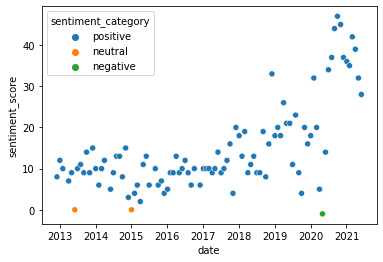

In [88]:
summary_sentiment_df = caluclate_sentiment_scores_afinn(summary_corpus)
summary_sentiment_df

There is only one negative sentiment score in the entire set. Perhaps the summaries are genereally positive regardess of the business environment.

In [89]:
# Find a sample of each extreme sentiment score
max_sent_idx = summary_sentiment_df[summary_sentiment_df['sentiment_score'] == summary_sentiment_df['sentiment_score'].max()].index
min_sent_idx = summary_sentiment_df[summary_sentiment_df['sentiment_score'] == summary_sentiment_df['sentiment_score'].min()].index

# Show the most negative sentiment score sample, (first 500 chars)
print(f'Most Negative Summary:')
print(min_sent_idx.date)
pprint(summary_sentiment_df.loc[min_sent_idx,'corpus'].values[0][:500])

Most Negative Summary:
[datetime.date(2020, 5, 1)]
('Production , New Orders , Employment Contracting ; Supplier Deliveries '
 'Slowing Faster Rate ; Backlog Contracting ; Raw Materials Inventories '
 'Contracting ; Customers Inventories Low ; Prices Decreasing ; Exports '
 'Imports Contracting Economic activity manufacturing sector contracted April '
 ', overall economy contracted 131 consecutive months expansion , say nations '
 'supply executives latest Manufacturing ISM Report Business. " April PMI '
 'registered 41.5 percent , 7.6 percentage points March reading 49.')


In [90]:
# Show the most postive sentiment score sample, (first 500 chars)
print(f'Most Positive Summary:')
print(max_sent_idx.date)
pprint(summary_sentiment_df.loc[max_sent_idx, 'corpus'].values[0][:500])

Most Positive Summary:
[datetime.date(2020, 10, 1)]
('New Orders Production Growing ; Employment Contracting ; Supplier Deliveries '
 'Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories '
 'Contracting ; Customers Inventories Low ; Prices Increasing ; Exports '
 'Imports Growing Economic activity manufacturing sector grew September , '
 'overall economy notching fifth consecutive month growth , say nations supply '
 'executives latest Manufacturing ISM Report Business. " September PMI '
 'registered 55.4 percent , 0.6 percentage point August reading 56 perc')


##### WRAS

,corpus,sentiment_score,sentiment_category
date,,,
2012-12-03,"Conditions still appear positive continued growth sales. "" Business steady , not much that. lull. "" principle business conditions affect company next three four quarters U.S. federal government ta...",-5.0,negative
2013-01-02,"Many Chinese sources coming us cost reductions maintain current business volumes. "" Saw stronger expected demand October November , December demand weak comparatively. "" seeing stabilization order...",8.0,positive
2013-02-01,"Fiscal cliff , uncertainty general EU economic weakness factors causing customers tentative commitments product purchases 2013. "" Midwest drought impact felt least midyear , impacting protein , sw...",6.0,positive
2013-04-01,"Beginning feel seasonal upswing business energy resin remain concern. "" Medical reimbursements insurance companies , particularly Medicare , slowing. "" second half 2013 looks promising , first hal...",11.0,positive
2013-05-01,"Business described flat best. "" Production still strong ; several new projects support alternative energy. "" Slight uptick business , overall continuing slowdown defense due budget/sequester. "" co...",11.0,positive
...,...,...,...
2021-02-01,"Supplier factory capacity well utilized. Increased demand , labor constraints upstream supply delays pushing lead times. prevalent international U.S.-based suppliers. "" Business remains strong. Ma...",12.0,positive
2021-03-01,coronavirus [ COVID-19 ] pandemic affecting us terms getting material build local overseas third- fourth-tier suppliers. Suppliers complaining [ lack ] available resources [ people ] manufacturing...,-13.0,negative
2021-04-01,"Late-winter storms unexpected [ areas ] U.S. organization exercising business-continuity plans much aggressive scale anticipated. storms slowed supply chain , could meet orders , even though short...",10.0,positive


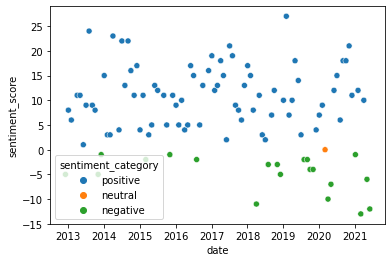

In [91]:
wras_sentiment_df = caluclate_sentiment_scores_afinn(wras_corpus)
wras_sentiment_df

There is a mixxture of positive and negative sentiment scores, and almost no neutral scores. Perhaps the compilers of the report like to pick  both negative and positive quotes to include in the report (likely manually--not programatically).

In [92]:
max_sent_idx = wras_sentiment_df[wras_sentiment_df['sentiment_score'] == wras_sentiment_df['sentiment_score'].max()].index
min_sent_idx = wras_sentiment_df[wras_sentiment_df['sentiment_score'] == wras_sentiment_df['sentiment_score'].min()].index

print(min_sent_idx.date)
print(f'Most Negative WRAS:')
pprint(wras_sentiment_df.loc[min_sent_idx, 'corpus'].values[0][:500])

[datetime.date(2021, 3, 1)]
Most Negative WRAS:
('coronavirus [ COVID-19 ] pandemic affecting us terms getting material build '
 'local overseas third- fourth-tier suppliers. Suppliers complaining [ lack ] '
 'available resources [ people ] manufacturing , creating major delivery '
 'issues. " Supply chains depleted ; inventories supply chain empty. Lead '
 'times increasing , prices increasing , [ ] demand increasing. Deep freeze '
 'Gulf Coast expected extend duration shortages. " Steel prices increased '
 'significantly recent months , driving costs suppliers propo')


In [93]:
# Show the most postive sentiment score sample, (first 500 chars)
print(max_sent_idx.date)
print(f'Most Positive WRAS:')
pprint(wras_sentiment_df.loc[max_sent_idx, 'corpus'].values[0][:500])

[datetime.date(2019, 2, 1)]
Most Positive WRAS:
('Unlike last years , experiencing first quarter slowdown. " Steady supply '
 'production environment. " Concerns oil prices fueling questions strong '
 'economy first half 2019. " Overall , business continues good ; however , '
 'margins squeezed. " federal government shutdown impacting ability get new '
 'products launched. wines need TTB [ Alcohol Tobacco Tax Trade Bureau ] '
 'approval. reforecasting accordingly. " continue enjoy benefits strong '
 'general economy. busy maintain backlog sales orders. " Incoming orde')


#### Using TextBlob lexicon

In [94]:
summary_corpus

['Economic activity manufacturing sector contracted November following two months modest expansion , overall economy grew 42nd consecutive month , say nations supply executives latest Manufacturing ISM Report Business. " PMI registered 49.5 percent , decrease 2.2 percentage points Octobers reading 51.7 percent , indicating contraction manufacturing fourth time last six months. months PMI reading reflects lowest level since July 2009 PMI registered 49.2 percent. New Orders Index registered 50.3 percent , decrease 3.9 percentage points October , indicating growth new orders third consecutive month. Production Index registered 53.7 percent , increase 1.3 percentage points , indicating growth production second consecutive month. Employment Index registered 48.4 percent , decrease 3.7 percentage points , indexs lowest reading since September 2009 Employment Index registered 47.8 percent. Prices Index registered 52.5 percent , reflecting decrease 2.5 percentage points. Comments panel month g

In [95]:
type(summary_corpus[1])


str

In [96]:
from textblob import TextBlob

def calculate_sentiment_scores_textblob(corpus, show_plot=True, return_df=True):
  sentiment_scores_tb = [round(TextBlob(release).sentiment.polarity, 3) for release in corpus]
  sentiment_category_tb = ['positive' if score > 0 
                              else 'negative' if score < 0 
                                  else 'neutral' 
                                      for score in sentiment_scores_tb]

  # Make dataframe
  sentiment_tb_df = pd.DataFrame([corpus, sentiment_scores_tb, sentiment_category_tb]).T
  sentiment_tb_df.columns = ['corpus', 'sentiment_score', 'sentiment_category']
  sentiment_tb_df['sentiment_score'] = sentiment_tb_df['sentiment_score'].astype('float')
  sentiment_tb_df['date'] = dates_ser[::-1].reset_index(drop=True)
  sentiment_tb_df = sentiment_tb_df.set_index('date')

  # Vizualize the dataframe
  if show_plot:
    sns.scatterplot(data=sentiment_tb_df,
                    x='date',
                    y='sentiment_score',
                    hue='sentiment_category',
                    hue_order=['positive', 'neutral', 'negative'])
  if return_df:
    return sentiment_tb_df

#### Summary

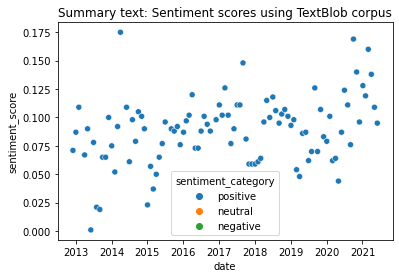

In [97]:
calculate_sentiment_scores_textblob(summary_corpus, return_df=False)
plt.title('Summary text: Sentiment scores using TextBlob corpus');

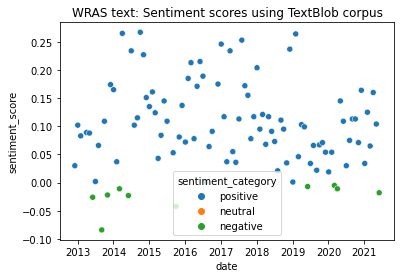

In [98]:
calculate_sentiment_scores_textblob(wras_corpus, return_df=False)
plt.title('WRAS text: Sentiment scores using TextBlob corpus');

# Feature Engineering & Text Representation

# Count-based Feature Engineering Models

Count-based are effective methods for extracting features from text. However, 
due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence, and context around nearby words in each text document.

## Advantages:
* Easy to understand, implement, and explain.
* Reproducible, and often deterministic
* Low computational cost
* Does not require much training data

## Disadvantages:
* Low performance


In [99]:
norm_summary_corpus_df = pd.DataFrame(norm_corpus_summary, columns=['document'])
norm_summary_corpus_df.head()

,document
0,economic activity manufacturing sector contract november follow two month modest expansion overall economy grow nd consecutive month say nation supply executive late manufacturing ism report busin...
1,economic activity manufacturing sector expand december follow one month contraction overall economy grow rd consecutive month say nation supply executive late manufacturing ism report business pmi...
2,report reflect u department commerce recently complete annual adjustment seasonal factor use calculate index economic activity manufacturing sector expand january second consecutive month overall ...
3,economic activity manufacturing sector expand march fourth consecutive month overall economy grow th consecutive month say nation supply executive late manufacturing ism report business pmi regist...
4,economic activity manufacturing sector expand april fifth consecutive month overall economy grow th consecutive month say nation supply executive late manufacturing ism report business pmi registe...


## Bag of Words Model

In [100]:
from sklearn.feature_extraction.text import CountVectorizer

# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus_summary)
cv_matrix

<99x706 sparse matrix of type '<class 'numpy.int64'>'
	with 11841 stored elements in Compressed Sparse Row format>

In [101]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix.toarray(), columns=vocab).tail()

,abate,ability,absenteeism,account,achieve,across,action,actively,activity,add,addition,additionally,address,adequately,adjust,adjustment,adverse,aerospace,affect,agreement,albeit,allied,along,also,although,aluminum,amid,among,annual,another,anticipate,apparel,appear,appliance,applicable,application,approach,approximately,april,aprils,...,trouble,turbulence,two,typical,unadjusted,uncertain,uncertainty,unchanged,undesired,unrest,upbeat,upon,upside,use,user,value,variable,view,volatility,volume,watch,watchful,weak,weaken,weakness,weather,weight,well,west,whether,whole,wide,winter,wood,work,workaround,worker,would,year,zero
94,1,0,1,0,0,0,0,0,2,0,0,0,0,0,5,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,2,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
95,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
96,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
97,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
98,0,0,1,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,14,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0


## Bag of N-Grams Model

In [102]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
# 2,2 to get bigrams only
# or 3,3, to get trigrams only
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus_summary)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab).tail()

,abate import,abate say,ability respond,absenteeism short,account overall,achieve year,across country,across entire,across industry,across many,action global,action input,actively evaluate,activity apparel,activity chemical,activity computer,activity continue,activity contracting,activity dramatically,activity electrical,activity fabricate,activity food,activity furniture,activity historic,activity include,activity machinery,activity manufacturing,activity miscellaneous,activity nonmetallic,activity paper,activity petroleum,activity plastic,activity primary,activity september,activity textile,activity transportation,activity two,activity wood,add cost,add positively,...,well perform,well seventh,well sixth,well supplier,well support,well th,well third,west coast,whether government,whole learn,wide scale,winter high,wood product,work action,work june,work late,work survey,workaround add,worker absenteeism,worker cause,worker continue,worker remain,would consume,year among,year cap,year comment,year continue,year forward,year high,year increase,year indicate,year lead,year manufacturing,year new,year percentage,year positive,year say,year six,zero expansion,zero price
94,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## TF-IDF Model

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., 
                     max_df=0.99, # Discard words that appear in 99% of the documents
                     norm='l2',
                     use_idf=True, 
                     smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus_summary)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab).tail()

,abate,ability,absenteeism,account,achieve,across,action,actively,add,addition,additionally,address,adequately,adjust,adjustment,adverse,aerospace,affect,agreement,albeit,allied,along,also,although,aluminum,amid,among,annual,another,anticipate,apparel,appear,appliance,applicable,application,approach,approximately,april,aprils,area,...,trouble,turbulence,two,typical,unadjusted,uncertain,uncertainty,unchanged,undesired,unrest,upbeat,upon,upside,use,user,value,variable,view,volatility,volume,watch,watchful,weak,weaken,weakness,weather,weight,well,west,whether,whole,wide,winter,wood,work,workaround,worker,would,year,zero
94,0.06,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.23,0.04,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.04,0.00,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.06,0.0,0.0,...,0.00,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
95,0.00,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.06,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.00,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
96,0.00,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.05,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.00,0.0,0.0,0.05,0.0,0.0,0.0
97,0.00,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.05,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.07,0.0,0.00,0.06,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.18,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.00,0.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
98,0.00,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.00,0.00,0.0,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.06,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.41,0.0,0.0,...,0.07,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0


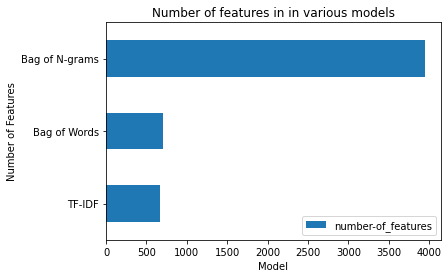

In [104]:
models_df = pd.Series([cv_matrix.shape[1], bv_matrix.shape[1], tv_matrix.shape[1]], 
                      index=['Bag of Words', 'Bag of N-grams', 'TF-IDF'], 
                      name='number-of_features').sort_values().to_frame()
models_df.plot(kind='barh')
plt.title('Number of features in in various models')
plt.ylabel('Number of Features')
plt.xlabel('Model');

We can see that there's about 5 times more features in the bag of n-grams model compared to the bag- of words model. TF-IDF has slightly fewer features than Bag of Words because we set teh TFIDF Vectorizer to drop words that occur in more than 99% of the documents.

## Document Similarity

Using the output of the TF-IDF Vectorizer, compare the similarity of the adjacent documents.

### Cosine Similarity

cosine_similarity is (1 - cosine_distance).

In [105]:
from sklearn.metrics.pairwise import pairwise_distances

cos_similarity_matrix = 1 - pairwise_distances(tv_matrix, metric='cosine')
cos_similarity_df = pd.DataFrame(cos_similarity_matrix)
cos_similarity_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
94,0.154324,0.271886,0.515150,0.132784,0.149488,0.137896,0.155152,0.098610,0.114448,0.107488,0.086972,0.099412,0.341279,0.551924,0.208349,0.109786,0.139801,0.133540,0.112147,0.118458,0.141648,0.115669,0.110427,0.296292,0.632857,0.263111,0.122302,0.134603,0.178470,0.117982,0.126658,0.099034,0.114082,0.091918,0.344345,0.596807,0.275449,0.137118,0.163023,0.165007,...,0.366659,0.300463,0.360666,0.368605,0.278271,0.338489,0.332203,0.314091,0.349120,0.346538,0.423296,0.606000,0.431850,0.332539,0.330893,0.373432,0.271413,0.314878,0.293030,0.258866,0.261071,0.264636,0.405147,0.680334,0.480334,0.303702,0.351005,0.404237,0.320741,0.415527,0.408966,0.410399,0.454187,0.512908,0.699601,1.000000,0.644741,0.482671,0.520573,0.538809
95,0.155515,0.169793,0.366777,0.257221,0.145961,0.130108,0.179835,0.106161,0.149823,0.133164,0.090976,0.109516,0.095770,0.314318,0.544455,0.290496,0.136280,0.139138,0.134395,0.130329,0.137418,0.141889,0.121950,0.102527,0.298435,0.533973,0.267931,0.131680,0.190886,0.112981,0.133468,0.106167,0.131910,0.104402,0.109190,0.265492,0.597047,0.282726,0.147151,0.171756,...,0.629250,0.417170,0.369721,0.384355,0.313348,0.357206,0.343671,0.293047,0.359117,0.349445,0.286829,0.441590,0.641322,0.433370,0.353560,0.396077,0.304522,0.331047,0.305382,0.288339,0.309175,0.312071,0.286537,0.417055,0.702375,0.389788,0.328573,0.389944,0.290716,0.406111,0.419831,0.425978,0.461117,0.493891,0.529646,0.644741,1.000000,0.621979,0.533670,0.552979
96,0.139389,0.140873,0.106226,0.498571,0.157187,0.141515,0.183709,0.114851,0.138659,0.155296,0.099640,0.123321,0.109518,0.091351,0.389570,0.447123,0.161466,0.123340,0.132582,0.176765,0.161674,0.155049,0.133227,0.120181,0.111761,0.324902,0.467778,0.258934,0.187837,0.108132,0.148972,0.113205,0.147321,0.101139,0.113172,0.118216,0.324442,0.554506,0.281828,0.149643,...,0.489614,0.618708,0.483028,0.392052,0.327318,0.378124,0.365816,0.337274,0.351409,0.349324,0.269021,0.310805,0.433245,0.584578,0.435934,0.324942,0.280573,0.310010,0.288735,0.277460,0.282048,0.283822,0.258363,0.265803,0.434867,0.552329,0.413963,0.367785,0.286898,0.399636,0.426432,0.414647,0.454706,0.475105,0.495514,0.482671,0.621979,1.000000,0.785696,0.649897
97,0.151038,0.142681,0.101777,0.403007,0.269430,0.192651,0.179524,0.110493,0.134157,0.135026,0.092330,0.121084,0.107938,0.101559,0.118708,0.330035,0.218400,0.137593,0.126766,0.213443,0.172633,0.145722,0.139484,0.126811,0.122869,0.127587,0.282318,0.510878,0.255379,0.104042,0.161169,0.120751,0.145287,0.106105,0.111841,0.099206,0.125812,0.387462,0.528975,0.235668,...,0.275212,0.497836,0.659728,0.462672,0.330798,0.401435,0.374527,0.352657,0.380115,0.363665,0.314415,0.327366,0.339718,0.414627,0.567617,0.405028,0.284851,0.346775,0.322186,0.298950,0.286348,0.288373,0.272871,0.259864,0.322930,0.435053,0.561966,0.432212,0.310500,0.416460,0.438171,0.425670,0.458669,0.493907,0.523164,0.520573,0.533670,0.785696,1.000000,0.750079
98,0.139888,0.142967,0.110794,0.143056,0.277561,0.325419,0.262102,0.119448,0.143242,0.144605,0.095356,0.159272,0.135801,0.090040,0.116988,0.144651,0.399846,0.286908,0.128746,0.206661,0.177110,0.158985,0.131606,0.115202,0.116672,0.113857,0.119313,0.285358,0.443616,0.210113,0.140076,0.109881,0.147581,0.101352,0.109163,0.101324,0.125209,0.155196,0.325353,0.494765,...,0.297013,0.403829,0.555148,0.666518,0.446483,0.423045,0.409305,0.371392,0.425324,0.371776,0.307103,0.346839,0.339837,0.327590,0.412650,0.549277,0.369218,0.352045,0.315674,0.285754,0.294073,0.299394,0.288974,0.267788,0.326773,0.290442,0.415133,0.588475,0.393458,0.437405,0.434518,0.426218,0.483489,0.505110,0.533316,0.538809,0.552979,0.649897,0.750079,1.000000


### [Jaccard Similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html)

Jaccard_similarity is (1 - Jaccard_distance).

In [106]:
from sklearn.metrics import pairwise_distances

jac_similarity_matrix = 1 - pairwise_distances(tv_matrix, metric='jaccard')
jac_similarity_df = pd.DataFrame(jac_similarity_matrix)
jac_similarity_df.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
94,0.252525,0.251232,0.303867,0.244565,0.268817,0.236842,0.245989,0.241935,0.221622,0.224599,0.231959,0.225806,0.205263,0.300000,0.248649,0.231579,0.233696,0.269663,0.243243,0.251309,0.266304,0.234973,0.247312,0.223958,0.326087,0.240642,0.246231,0.241758,0.270833,0.218274,0.240642,0.239130,0.245989,0.210811,0.244444,0.322404,0.240437,0.243094,0.215909,0.259887,...,0.328042,0.349282,0.351759,0.350000,0.312500,0.333333,0.337900,0.322727,0.376884,0.380488,0.360406,0.363184,0.341709,0.354369,0.349754,0.344498,0.328571,0.364929,0.354839,0.375610,0.357143,0.353774,0.373874,0.413462,0.405000,0.386364,0.427230,0.434978,0.432432,0.487805,0.495763,0.516129,0.552885,0.687805,0.772021,1.000000,0.706186,0.564815,0.554054,0.529148
95,0.269231,0.274194,0.237288,0.261905,0.273256,0.252874,0.270588,0.251462,0.244048,0.254438,0.233333,0.226744,0.204545,0.236559,0.266272,0.276471,0.250000,0.290123,0.267857,0.275862,0.270588,0.266667,0.272189,0.238636,0.254144,0.257310,0.276243,0.266667,0.297143,0.225275,0.257310,0.263473,0.263158,0.239521,0.254545,0.264045,0.272727,0.276074,0.231250,0.295597,...,0.376471,0.387435,0.384615,0.375000,0.347368,0.356383,0.366337,0.336585,0.419890,0.392670,0.364130,0.331606,0.358696,0.357513,0.389189,0.382199,0.378947,0.396907,0.371287,0.402116,0.425532,0.421053,0.404878,0.378109,0.434783,0.384615,0.406863,0.429245,0.406542,0.476923,0.480176,0.536946,0.577320,0.645000,0.692708,0.706186,1.000000,0.654639,0.623762,0.620000
96,0.233161,0.232323,0.215054,0.273256,0.255556,0.236264,0.245810,0.241573,0.220339,0.251429,0.224599,0.217877,0.196721,0.227979,0.248588,0.251397,0.247126,0.263158,0.242938,0.272222,0.267045,0.255814,0.268571,0.243094,0.238095,0.261364,0.265957,0.241379,0.285714,0.223404,0.261364,0.252874,0.252809,0.222857,0.236994,0.254054,0.247126,0.257310,0.214286,0.267857,...,0.346369,0.402062,0.385027,0.375661,0.355670,0.371728,0.367150,0.370732,0.375000,0.378788,0.336788,0.313433,0.338542,0.338308,0.353846,0.334975,0.331683,0.356098,0.358852,0.387755,0.381910,0.385000,0.365741,0.333333,0.382653,0.365741,0.386792,0.390135,0.381166,0.425121,0.447257,0.456621,0.497608,0.562791,0.573460,0.564815,0.654639,1.000000,0.861111,0.706186
97,0.225000,0.224390,0.213542,0.255556,0.266304,0.234043,0.250000,0.239130,0.218579,0.234973,0.222798,0.216216,0.195767,0.232323,0.239130,0.241935,0.237569,0.259887,0.240437,0.275676,0.263736,0.245810,0.258242,0.240642,0.242268,0.244565,0.262887,0.245810,0.268421,0.215385,0.251366,0.250000,0.250000,0.214286,0.234637,0.238342,0.244444,0.240223,0.212644,0.264368,...,0.319149,0.388060,0.371134,0.355330,0.336634,0.365482,0.361502,0.352113,0.361809,0.365854,0.345178,0.296651,0.326633,0.333333,0.334975,0.336538,0.333333,0.357143,0.359813,0.388060,0.375610,0.365385,0.372727,0.328767,0.376238,0.348214,0.380734,0.384279,0.387665,0.417840,0.428571,0.442478,0.467890,0.545045,0.547945,0.554054,0.623762,0.861111,1.000000,0.715736
98,0.205000,0.216749,0.198953,0.226519,0.231183,0.225806,0.248619,0.224044,0.223464,0.219780,0.202073,0.201087,0.174603,0.206030,0.217391,0.220430,0.222222,0.251429,0.218579,0.247312,0.241758,0.223464,0.229508,0.232432,0.240838,0.209677,0.223350,0.216667,0.247368,0.226316,0.229508,0.227778,0.228261,0.198895,0.212291,0.223958,0.215470,0.217877,0.203488,0.248555,...,0.318919,0.368159,0.357513,0.369792,0.364103,0.352041,0.355450,0.345972,0.369231,0.352941,0.338462,0.315271,0.326531,0.307692,0.328358,0.336585,0.326829,0.338095,0.341121,0.354680,0.362745,0.372549,0.360731,0.334884,0.390863,0.336323,0.381395,0.378855,0.376106,0.412322,0.400810,0.437500,0.490566,0.520179,0.543779,0.529148,0.620000,0.706186,0.715736,1.000000


In [107]:
# Check the correlation of the two methods of calculating simlilarity
jac_similarity_df.corrwith(cos_similarity_df).mean()

0.5431107789923809

## Clustering documents using similarity features

### Using Cosine Similarity

In [108]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_cos = linkage(cos_similarity_matrix, 'ward')
# pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object').tail()

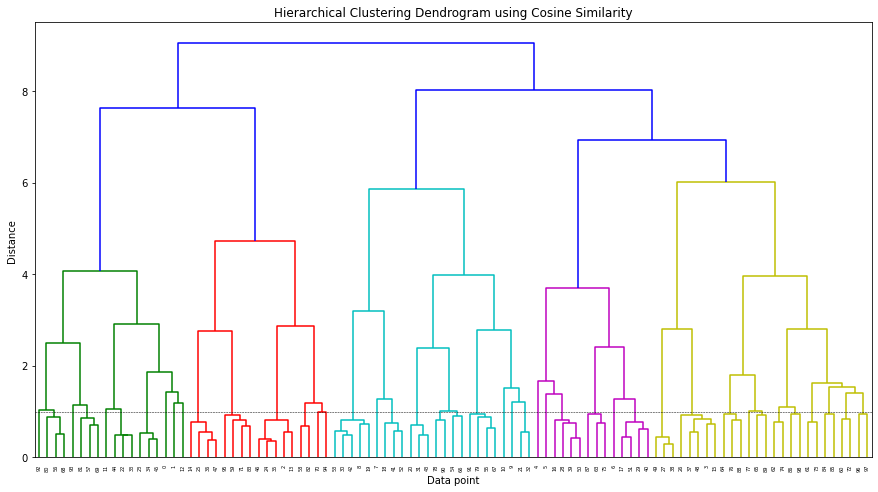

In [109]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram using Cosine Similarity')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z_cos)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [110]:
from scipy.cluster.hierarchy import fcluster
max_dist = 0.5

cluster_labels_cos = fcluster(Z_cos, max_dist, criterion='distance')
cluster_labels_cos = pd.Series(cluster_labels_cos, name='cluster_label_using_cosine_similarity')
# cluster_labels_cos.value_counts()

### Using Jaccard Similarity

In [111]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_jac = linkage(jac_similarity_matrix, 'ward')
# pd.DataFrame(Z_jac, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object').tail()



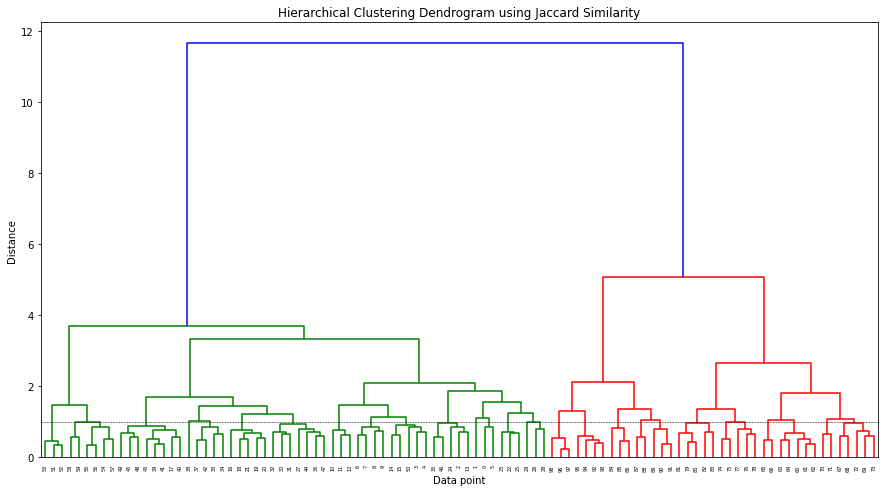

In [112]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram using Jaccard Similarity')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z_jac)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [113]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels_jac = fcluster(Z_jac, max_dist, criterion='distance')
cluster_labels_jac = pd.Series(cluster_labels_jac, name='cluster_label_using_jaccard_similarity')
# cluster_labels_jac.value_counts()

## Topic Models

In [114]:
n_components = 5
n_top_words = 20
max_iter = 1000

### Using [NMF](https://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf)

>The time complexity is polynomial in NMF.

In [115]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=n_components,
          beta_loss='kullback-leibler', 
          solver='mu', 
          max_iter=max_iter, 
          alpha=.1,
          l1_ratio=.5)
dt_matrix_nmf = nmf.fit_transform(tv_matrix)
features_nmf = pd.DataFrame(dt_matrix_nmf, columns=[f'Topic_{i}' for i in range(n_components)])
features_nmf.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
94,0.330250,2.824954e-01,0.000000,8.386654e-03,2.477003e-29
95,0.293008,1.410151e-01,0.188144,0.000000e+00,0.000000e+00
96,0.232919,6.109198e-16,0.545815,0.000000e+00,0.000000e+00
97,0.233213,6.976032e-44,0.584510,0.000000e+00,0.000000e+00
98,0.245879,0.000000e+00,0.550670,5.591150e-27,0.000000e+00


In [116]:
# Show topics and their weights
tt_matrix_nmf = nmf.components_
for topic_weights in tt_matrix_nmf:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.5]
    print(topic)
    print()

[('reading', 0.6809956564643301), ('inventory', 0.5567755814786788), ('decrease', 0.5518934731157534)]

[('january', 1.0668065534007178), ('december', 0.5932857922883346)]

[('march', 0.9013780280802517), ('april', 0.7482629193985235), ('february', 0.5559593769055721)]

[('november', 0.8786503902816964), ('may', 0.6223754956001041)]

[('july', 0.7948312844579513), ('august', 0.6603581789641654), ('reading', 0.5382226235829228), ('june', 0.530582845547031)]



### Using [LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

>In LDA, the time complexity is proportional to (n_samples * iterations).

In [117]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=n_components, max_iter=max_iter)
dt_matrix_lda = lda.fit_transform(tv_matrix)
features_lda = pd.DataFrame(dt_matrix_lda, columns=[f'Topic_{i}' for i in range(n_components)])
features_lda

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,0.023982,0.023982,0.023978,0.904075,0.023982
1,0.023536,0.023536,0.023530,0.905863,0.023536
2,0.028022,0.028022,0.350931,0.565003,0.028022
3,0.031815,0.031815,0.031811,0.872745,0.031815
4,0.028414,0.028414,0.028412,0.886345,0.028414
...,...,...,...,...,...
94,0.018726,0.018726,0.087989,0.855833,0.018726
95,0.019340,0.019340,0.019338,0.922641,0.019340
96,0.018111,0.018111,0.018108,0.927559,0.018111
97,0.017582,0.017582,0.017577,0.929678,0.017582


In [118]:
# Show topics and their weights
tt_matrix_lda = lda.components_
for topic_weights in tt_matrix_lda:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.3]
    print(topic)
    print()

[]

[]

[('adjust', 2.9378225251489622), ('seasonally', 2.9378225251489622), ('annual', 0.9859627155185602), ('calculate', 0.9859627155185602), ('complete', 0.9859627155185602), ('recently', 0.9859627155185602), ('seasonal', 0.9859627155185602), ('use', 0.9859627155185602), ('applicable', 0.47673797516545885), ('commerce', 0.4083848594507715), ('department', 0.4083848594507715), ('pmitms', 0.4083848594507715), ('start', 0.4083848594507715), ('stage', 0.34940228140185947), ('kick', 0.3239065752221999)]

[('reading', 16.60354997130849), ('increase', 10.635064063841359), ('inventory', 8.984855629212197), ('decrease', 8.761819398614469), ('november', 8.460031519725366), ('august', 8.038859362872504), ('april', 7.9157752055063915), ('march', 7.901191464017491), ('february', 7.855123364349484), ('supplier', 7.789432999736995), ('january', 7.781493163439919), ('may', 7.778601540700446), ('price', 7.698706865808479), ('september', 7.6975758785441695), ('december', 7.6534056952934275), ('contin

In [119]:
# Check the correlations of NMF and LDA topic models
pd.DataFrame(tt_matrix_nmf).corrwith(pd.DataFrame(tt_matrix_lda)).mean()

-0.0733296643246655

The correlation shows that the NMF and LDA produce mostly uncorrelated output.

### Clustering documents using topic model features

Let's compares the labels assigned by a Kmeans model of the topics for NMF and LDA

In [120]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features_nmf)
cluster_labels_nmf = km.labels_
cluster_labels_nmf = pd.Series(cluster_labels_nmf, name='topic_labels_NMF', index=dates_ser)

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features_lda)
cluster_labels_lda = km.labels_
cluster_labels_lda = pd.Series(cluster_labels_lda, name='topic_labels_LDA', index=dates_ser)

# summary_df.join((cluster_labels_nmf, cluster_labels_lda))[['topic_labels_NMF','topic_labels_LDA', 'summary']]

# Check the correlation of cluster labels from NMF vs LDA 
cluster_labels_lda.corr(cluster_labels_nmf)

0.5288126312543033

We see that the two methods of cluster labels are also create uncorrelated output.

# Context-based Feature Engineering Models

Traditional models have some limitations considering sparse representations,
leading to feature explosion and the curse of dimensionality. This is in addition to the already mentioned loss of context, ordering, and sequence of related words in text data.

Advanced feature engineering models, which use deep learning and neural network models generate dense embeddings for every word in any corpus, while retaining the context, ordering, and sequence of related words.

## Advantages:
* High performance
* High computational cost
* Requires large mounts of training data

## Disadvantages:
* Difficult to understand, implement, and explain.
* Not deterministic (uses random parameters upon initialization)

## Word2Vec

Let's use the GenSim implementation of Word2Vec, which is optimized for large corpora.

Input: a corpus of documents
Output: feature vectors

Steps: 
1. tokenize our normalized corpus
2. tune the following four parameters in the Word2Vec model to build it. 

Parameters:
* `vector_size`: the dimension for the word vectors. Useful range: 10's to thousands. 
* `window`: the length of the window of words that should be considered for the algorithm to take into account as context when training. Useful range: probably range(0-100). 
* `min_count`: This parameter specifies the minimum word count needed across the corpus for the word to be considered in the vocabulary. This helps remove very specific words that may not have much significance since they occur very rarely in the documents.
* `sample`: This parameter is used to downsample effects of occurrence of frequent words. Useful range: between 0.01 and 0.0001.

For each parameter: Pick the one that performs best in cross-validation.

In [121]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus_summary]

# Set values for various parameters
vector_size = 20    # Word vector dimensionality  
window = 20         # Context window size                                                                                    
min_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=vector_size, 
                          window=window, min_count=min_count,
                          sample=sample, epochs=200)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['grow', 'contract', 'month', 'slow', 'fast', 'delivery', 'customer', 'furniture', 'electronic']}

print("similar words based on gensim's word2vec model, where key is the word")
print('and the values are the top 5 words appearing in the context of the key word')
similar_words



/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


similar words based on gensim's word2vec model, where key is the word
and the values are the top 5 words appearing in the context of the key word


{'contract': ['contracting', 'grow', 'sector', 'expand', 'notch'],
 'customer': ['respectably', 'contracting', 'fast', 'slow', 'match'],
 'delivery': ['supplier', 'inventory', 'strengthen', 'gain', 'primarily'],
 'electronic': ['product', 'machinery', 'primary', 'paper', 'apparel'],
 'fast': ['slow', 'contracting', 'rate', 'grow', 'growing'],
 'furniture': ['paper', 'product', 'wood', 'chemical', 'industry'],
 'grow': ['contracting', 'fast', 'notch', 'slow', 'economic'],
 'month': ['consecutive', 'fifth', 'fourth', 'business', 'pmi'],
 'slow': ['fast', 'contracting', 'grow', 'rate', 'unchanged']}

The sample output here makes sense.

### Build framework for getting document level embeddings

In [122]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [123]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=vector_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.565672,-1.268246,-1.110700,0.195197,-1.622801,-0.313521,-0.171360,-0.501148,-0.418110,1.099350,-1.139986,1.456215,0.975947,0.894718,0.352818,1.397203,-1.261158,-1.911790,-1.565649,0.404343
1,0.859611,-0.845547,-1.010256,0.222071,-0.751070,-0.141162,-0.093675,-1.018892,-0.000965,0.710606,-1.166933,1.157261,0.669025,0.532807,-0.175716,1.256937,-0.760065,-1.731624,-1.211734,0.703426
2,0.682358,-0.830310,-2.487255,0.484658,-1.124334,-0.573419,0.119012,-1.992149,-0.888557,1.370054,-1.082381,0.717171,1.649239,0.252150,0.332332,1.346322,-1.265803,-1.502578,-0.068820,-0.205305
3,0.704952,-0.950635,-2.553719,1.050128,-0.569211,-0.450116,-0.238970,-0.902195,-0.558540,1.417492,-0.880969,1.501909,1.285157,-0.133774,0.455608,1.472937,-2.090534,-1.032474,-0.904673,-0.644699
4,0.358661,-1.212043,-1.858567,0.952139,-1.292416,0.011489,-0.209043,-0.665287,-0.551580,1.613457,-1.207987,1.397074,1.328812,0.638573,0.261355,1.501929,-1.827482,-1.726243,-1.298276,-0.098061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.816101,-0.936474,-0.043090,-1.338438,-1.118997,-0.084161,-0.899081,1.214873,-1.687674,1.188207,0.928893,0.830731,0.627997,0.943977,0.614137,0.506278,-0.801964,-1.022552,-1.085537,-0.291607
95,0.736343,-0.627596,-0.302141,-1.082852,-0.823109,-0.438513,-0.875472,1.154921,-1.393428,1.280859,0.676138,1.192168,0.459149,0.683965,0.757266,0.420843,-0.841170,-0.853722,-1.424199,-0.682841
96,0.367465,-0.657401,0.135221,-0.749380,-0.711567,-0.304777,-0.699860,1.576438,-1.049269,1.484568,0.720508,1.317808,0.180566,0.436120,0.646272,0.586660,-0.987150,-0.603868,-1.609765,-0.934619
97,0.474904,-0.806634,0.289745,-0.611128,-0.714297,-0.044898,-0.685573,1.704810,-0.971098,1.473920,0.724364,1.214563,0.170245,0.649841,0.400305,0.424638,-0.910888,-0.654597,-1.436083,-0.910245


### Clustering with word embeddings

In [124]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(random_state=None)
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.Series(cluster_labels, name='w2v_cluster_label')
# pd.concat([summary_df.reset_index(), cluster_labels], axis=1)[['clean_summary', 'w2v_cluster_label']].tail()

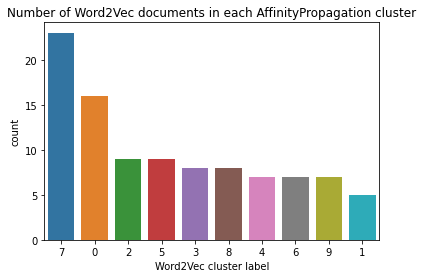

In [125]:
g = sns.countplot(x=cluster_labels, order=cluster_labels.value_counts().index)
g.set(title='Number of Word2Vec documents in each AffinityPropagation cluster',
      xlabel='Word2Vec cluster label');

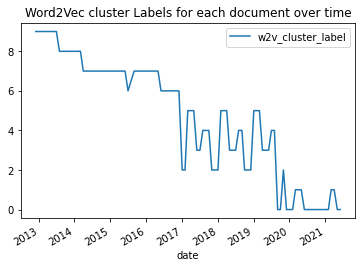

In [126]:
pd.DataFrame(cluster_labels).set_index(dates_ser).plot()
plt.title('Word2Vec cluster Labels for each document over time');

The cluster labels tends to stay the same for consecutive months (high autocorrelation). This makes sense, as the words in the documents should be similar for similar dates as the topics written in the monthly news releases are not expected to be very different each month.

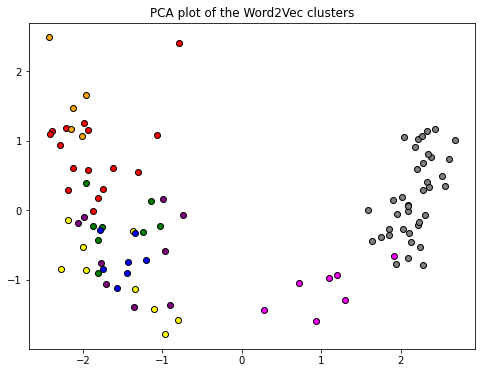

In [127]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
# categories = list(summary_corpus_df['Category'])
plt.figure(figsize=(8, 6))
plt.title('PCA plot of the Word2Vec clusters')
colors_dict = {0: 'red', 1: 'orange', 2:'yellow', 3:'green', 4:'blue', 5:'purple', 6:'magenta'}

for i in range(len(labels)):
  label = labels[i]
  # color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
  color = colors_dict[label] if label in colors_dict.keys() else 'grey'
  # annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c=color, edgecolors='k')
  # plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## GloVe (Global Vectors)

Let's use the Spacy implementation of GloVe.



## Visualize GloVe word embeddings


In [128]:
nlp = spacy.load('en_core_web_md')
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus_summary] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
read,0.068879,0.259700,-0.27460,0.084049,0.11746,0.56099,0.274020,-0.431730,0.205660,1.9462,-0.44414,0.346480,0.034651,-0.124780,-0.653810,-0.193000,-0.088177,0.94849,-0.495060,-0.092329,0.077658,-0.143590,0.55160,-0.36120,0.180540,-0.058189,-0.037947,-0.379050,-0.073899,0.008460,-0.120240,0.181780,0.198720,-0.41881,0.011728,-0.005294,0.133630,0.446710,-0.105530,-0.245200,...,0.31666,-0.066089,-0.17598,0.60248,0.729480,-0.16004,0.048641,0.245810,0.691510,-0.016935,-0.43856,-0.166970,-0.100630,0.082339,-0.269720,0.619650,-0.15849,-0.076047,-0.24441,0.099114,-0.137620,-0.040680,0.327820,-0.53837,-0.183760,-0.061035,0.098814,0.022543,-0.004371,0.14317,-0.39947,-0.16171,-0.121910,-0.11313,0.385170,-0.177590,-0.031033,-0.365600,0.20514,-0.069834
especially,-0.388460,0.094481,-0.25283,-0.147250,0.23544,0.14032,0.389070,-0.051978,-0.159770,2.7245,-0.17403,-0.048721,0.247640,0.073965,0.012255,-0.055472,-0.009229,0.81244,-0.253490,-0.051029,-0.282100,-0.060429,-0.27442,-0.32737,0.034707,-0.102540,-0.026887,-0.152180,0.013894,-0.275910,-0.095586,0.005221,-0.095327,-0.26722,-0.003715,-0.047831,0.189500,-0.070577,-0.065654,0.076236,...,0.33150,-0.188060,-0.20183,0.25389,0.130670,0.15648,-0.016378,0.074809,0.497650,0.246450,-0.15990,-0.110730,-0.379810,-0.627060,-0.220040,0.169230,0.24485,0.317620,-0.15483,0.575520,0.011164,-0.156300,0.112610,-0.10456,0.202050,0.213740,0.527890,-0.270310,0.175310,-0.21838,-0.52739,-0.12610,-0.140260,-0.02416,-0.062215,0.402370,0.001485,-0.330650,0.04907,-0.097112
capital,0.327890,-0.207370,0.25799,-0.274520,0.23513,-0.22968,-0.477100,0.558980,-0.116850,2.9696,-0.93538,-0.185250,-0.001638,0.343350,-0.279770,0.410310,-0.162140,1.21250,0.013217,0.346800,0.423950,0.420410,-0.42682,-0.20642,-0.397420,-0.267340,-0.085760,0.301970,-0.398620,0.281240,0.459420,-0.226850,0.038693,0.20723,-0.078896,0.334310,-0.052561,-0.156440,0.060536,-0.447940,...,-0.19881,0.332330,-0.27548,0.71028,-0.117720,-0.78940,-0.203660,-0.267170,0.062856,-0.210280,-0.27373,-0.596380,0.027480,-0.166030,-0.116060,0.094069,0.51280,-0.635970,0.34387,0.099473,0.252070,-0.138330,-0.140420,0.21752,-0.420860,0.081098,0.239710,0.238570,-0.595600,0.14726,-0.60508,0.56011,-0.248260,-0.44290,-0.304960,-0.140180,-0.171680,-0.398870,-0.20615,-0.388580
loss,-0.705590,0.996190,-0.31034,0.827930,-0.89397,-0.15079,0.035647,0.133430,-0.021152,2.6743,-0.22561,-0.090369,-0.288210,0.115300,0.048975,-0.062586,0.430750,1.59130,-0.399680,0.330680,-0.179040,-0.241090,-0.20589,-0.42800,-0.061424,0.184980,-0.181010,0.016144,-0.200300,-0.070905,-0.399390,-0.367900,-0.479010,0.17292,0.018124,0.830690,0.248030,0.102430,-0.057297,-0.206040,...,-0.38535,-0.306440,0.65317,0.53257,0.359470,-0.29346,0.216030,-0.367170,0.143560,-0.242440,0.30215,0.057906,-0.059513,0.268420,0.150830,-0.113670,-0.21701,0.624120,0.16554,-0.058876,-0.784570,0.003049,-0.366450,0.70935,-0.297150,0.658710,-0.680630,-0.076068,0.560650,-0.09311,0.36434,0.17339,-0.174420,-0.34936,-0.051566,0.268380,-0.094066,-0.082802,0.33378,-0.456760
linger,-0.055125,-0.164450,-0.24150,0.458930,0.11045,-0.22026,-0.282860,0.165210,0.348600,1.8456,0.54674,-0.694570,-0.537720,-0.391610,-0.169840,-0.096221,0.202220,0.17335,0.201440,0.148970,-0.250940,0.461520,0.22064,0.13754,0.091113,-0.158560,0.546560,0.236690,-0.041568,-0.150390,0.095987,0.033779,-0.427490,-0.62129,-0.101600,0.534870,0.322190,0.018972,0.042141,0.027132,...,-0.55295,-0.248460,0.26212,0.42517,-0.028934,0.21983,-0.317110,-0.060364,-0.321460,0.092915,0.26144,-0.030584,0.228590,-0.924530,-0.020536,-0.150220,-0.14598,0.103380,-0.53796,0.724690,0.141180,-0.529540,-0.026021,0.12124,0.045542,-0.017057,0.313070,0.113590,0.089441,-0.13509,-0.16764,0.91010,-0.049716,-0.12995,-0.158420,0.006417,0

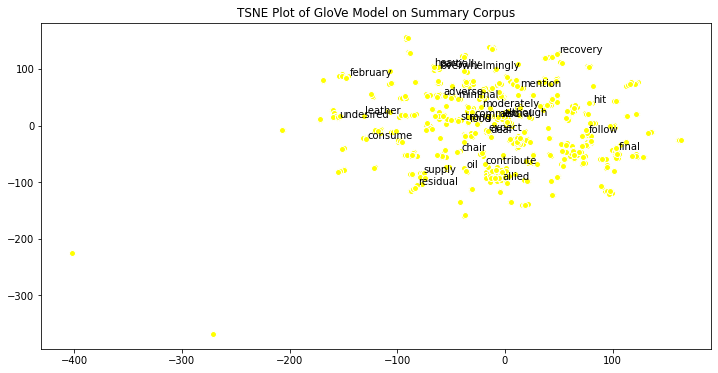

In [129]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='yellow', edgecolors='white')
skip_counter = 0
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  # annotate a small fraction of the plot
  if skip_counter == 24:
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    skip_counter=0
  else:
    skip_counter += 1
plt.title('TSNE Plot of GloVe Model on Summary Corpus');

There's no obvious pattern from the text annotations in the TSNE plot, but we can see  various small clusters and some  large clusters.

## FastText

In [130]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus_summary]

# Set values for various parameters
vector_size = 100    # Word vector dimensionality  
window = 50          # Context window size                                                                                    
min_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(sentences=tokenized_corpus, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=min_count,
                    sample=sample, 
                    sg=1, 
                    epochs=50)

# view similar words based on gensim's fasttext model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['grow', 'contract', 'month', 'slow', 'fast', 'delivery', 'customer', 'furniture', 'electronic']}

print("similar words based on gensim's fasttext model, where key is the word")
print('and the values are the top 5 words appearing in the context of the key word')
similar_words

similar words based on gensim's fasttext model, where key is the word
and the values are the top 5 words appearing in the context of the key word


{'contract': ['contracting', 'pmi', 'inventory', 'delivery', 'rate'],
 'customer': ['backlog', 'production', 'export', 'inventory', 'increase'],
 'delivery': ['supplier', 'inventory', 'import', 'pmi', 'slow'],
 'electronic': ['equipment', 'metal', 'product', 'coal', 'fabricate'],
 'fast': ['rate', 'slow', 'inventory', 'contract', 'production'],
 'furniture': ['related', 'product', 'metal', 'nonmetallic', 'miscellaneous'],
 'grow': ['increase', 'manufacturing', 'executive', 'late', 'ism'],
 'month': ['indicate', 'consecutive', 'production', 'increase', 'percentage'],
 'slow': ['inventory', 'rate', 'fast', 'delivery', 'grow']}

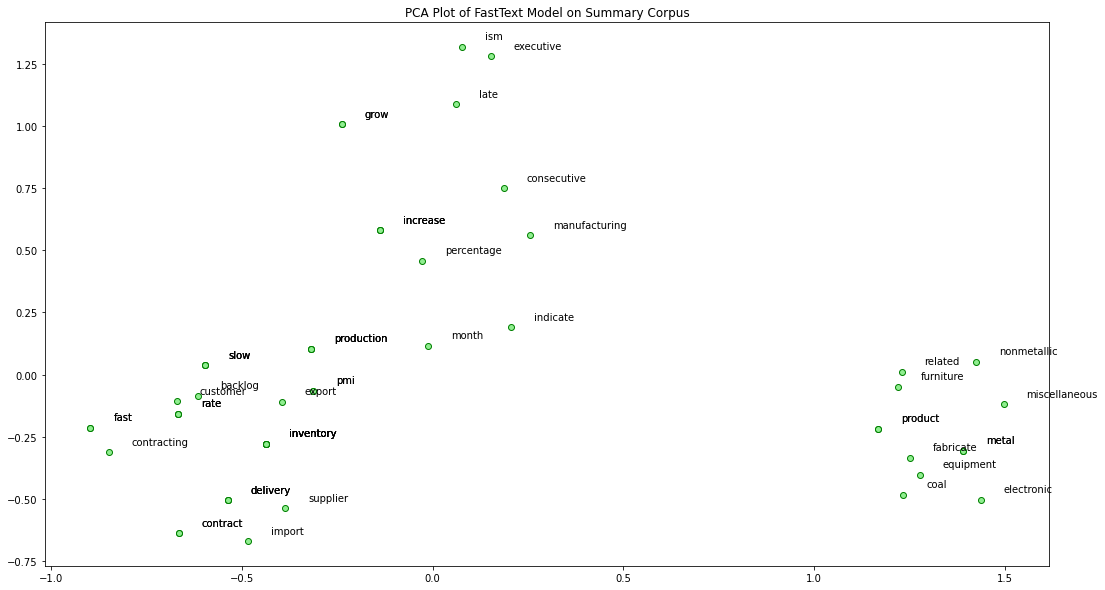

In [131]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')
plt.title('PCA Plot of FastText Model on Summary Corpus');

# Supervised Learning Models for Text Data


* (Multinomial) Naïve Bayes
* Logistic regression
* Support vector machines
* Random forest
* Gradient boosting machine

### Check the preprocessing before modeling

In [132]:
# Check dataframe
df.head(1)

,summary,wras,commodities_up_in_price,commodities_up_count,commodities_down_in_price,commodities_down_count,commodities_in_short_supply,commodities_short_count,gdp_growth_direction,clean_summary,clean_wras
date,,,,,,,,,,,
2012-12-03,"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's suppl...","Conditions still appear to be positive for continued growth in sales."" Business is steady, but not much more than that. We are in a lull."" The principle business conditions that will affect the co...","Aluminum Products, Caustic Soda, Corrugated Boxes/Packaging, Polypropylene, Propylene, Steel, Steel – Hot Rolled",7,"Fuel, Oil, Steel",3,None,1,0.0,economic activity manufacturing sector contract november follow two month modest expansion overall economy grow nd consecutive month say nation supply executive late manufacturing ism report busin...,condition still appear positive continued growth sale business steady not much lull principle business condition affect company next three four quarter u federal government tax budgetary policy im...


Check the distribution of the classes

In [133]:
from sklearn.model_selection import train_test_split

X = df.dropna()['clean_summary']
y = df.dropna()['gdp_growth_direction'].astype(int)

(train_corpus, test_corpus, 
   train_labels, test_labels) = train_test_split(X, y, test_size=0.25)

train_corpus.shape, test_corpus.shape

((69,), (24,))

In [134]:
# Check the size of the classes
from collections import Counter

trd = dict(Counter(train_labels))
tsd = dict(Counter(test_labels))

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd], 
             columns=['Target Label', 'Train Count', 'Test Count'])
.sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
1,0,40,11
0,1,29,13


The classes appear to be fairly unbalanced. There's about 10-20% more items in the '0 class, relative to the '1' class.

Check the Vectorizing of the tokens

In [135]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score

## CountVectorizer
# build BOW features on train articles
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
cv_train_features = cv.fit_transform(train_corpus)

# transform test articles into features
cv_test_features = cv.transform(test_corpus)

## TfidfVectorizer
# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)

# transform test articles into features
tv_test_features = tv.transform(test_corpus)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (69, 591)  Test features shape: (24, 591)
TFIDF model:> Train features shape: (69, 591)  Test features shape: (24, 591)


In [136]:
def plot_cv_results(cv_results, param_x: str, param_z: str, metric: str ='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, 
                  hue=col_z, 
                  data=cv_results, 
                  dodge=True, 
                  ci=99, 
                  n_boot=64, 
                  ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return ax

def plot_confusion_matrix(true, preds, *args, **kwargs):
  #Import needed libraries
  from sklearn.metrics import confusion_matrix

  ax = kwargs.get('ax', None)
  title = kwargs.get('title', None)

  cm = confusion_matrix(true, preds)
  tn, fp, fn, tp = confusion_matrix(true, preds).ravel()
  cm = [[tp,fp],[fn,tn]]
  
  #Plot the matrix
  sns.heatmap(cm, annot=True, fmt = "d", cmap=plt.cm.Blues, ax=ax)
  # labels, title and ticks
  plt.gca().set_xlabel('ACTUAL LABELS')
  plt.gca().set_ylabel('PREDICTED LABELS')
  plt.gca().set_title(title)


def plot_forecasts(true, pred, suptitle):
  forecast_df = pd.DataFrame({'true':true, 
                                  'pred':pred})
  fig, ax = plt.subplots(1, 2, figsize=(12,6))
  forecast_df.plot(ax=ax[0])
  plot_confusion_matrix(true, pred, ax=ax[1], normalize=True)
  fig.suptitle(suptitle)
  plt.show()

Split data with time-series split to do a walk-forward analysis during the grid search.

In [137]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Using time series split
# Make Grid Search splits
n_splits = int(0.2*len(train_labels))
gs_splits = TimeSeriesSplit(n_splits=n_splits, test_size=2)

X_gs = df.dropna().drop(columns='gdp_growth_direction').iloc[:-n_splits]
y_gs = df.dropna()['gdp_growth_direction'].iloc[:-n_splits]

# Make forecast splits
X = df.dropna().drop(columns='gdp_growth_direction')
y = df.dropna()['gdp_growth_direction']
forecast_splits = TimeSeriesSplit(n_splits=len(test_corpus),
                                  test_size=1)


In [138]:
# Make custom transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler 

# Cache reused transformers
from tempfile import mkdtemp
from shutil import rmtree

cachedir = mkdtemp()
# Clear the cache directory when you don't need it anymore
# rmtree(cachedir)

# diplays HTML representation in a jupyter context
from sklearn import set_config
set_config(display='diagram')   

from sklearn.naive_bayes import MultinomialNB

preprocessor = ColumnTransformer(
                [("summary_tfidf", TfidfVectorizer(), 'clean_summary'),
                ("wras_tfidf", TfidfVectorizer(), 'clean_wras'),
                ('commod_names_up_cv', CountVectorizer(), 'commodities_up_in_price'),
                ('commod_names-down_cv', CountVectorizer(), 'commodities_down_in_price'),
                ('commod_names-short_cv', CountVectorizer(), 'commodities_in_short_supply'),
                ('commod_count_scaler', MinMaxScaler(), ['commodities_up_count',
                                                    'commodities_down_count',
                                                    'commodities_short_count'])])
pipeline = Pipeline([('pre', preprocessor,),
                     ('clf', MultinomialNB())],
                    memory=cachedir)

pipeline.fit(X_gs,y_gs)

# visualize pipeline
pipeline

Pipeline(memory='/tmp/tmp8pmu86gi',
         steps=[('pre',
                 ColumnTransformer(transformers=[('summary_tfidf',
                                                  TfidfVectorizer(),
                                                  'clean_summary'),
                                                 ('wras_tfidf',
                                                  TfidfVectorizer(),
                                                  'clean_wras'),
                                                 ('commod_names_up_cv',
                                                  CountVectorizer(),
                                                  'commodities_up_in_price'),
                                                 ('commod_names-down_cv',
                                                  CountVectorizer(),
                                                  'commodities_down_in_price'),
                                                 ('commod_names-short_cv',
                                                  CountVectorizer(),
                                                  'commodities_in_short_supply'),
                                                 ('commod_count_scaler',
                                                  MinMaxScaler(),
                                                  ['commodities_up_count',
                                                   'commodities_down_count',
                                                   'commodities_short_count'])])),
                ('clf', MultinomialNB())])

## Baseline Modelling with word-based features

### (Multinomial) Naïve Bayes

Find best hyperparameters

In [139]:
from sklearn.naive_bayes import MultinomialNB

mnb_pipeline = Pipeline([('pre', preprocessor,),
                         ('mnb', MultinomialNB())],
                          memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1,6)],
              'mnb__alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-2, 1e-1, 1],
}

In [140]:
# gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_mnb = gs_mnb.fit(X_gs, y_gs)

# with open(working_path/'models/gs_mnb.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_mnb,f)

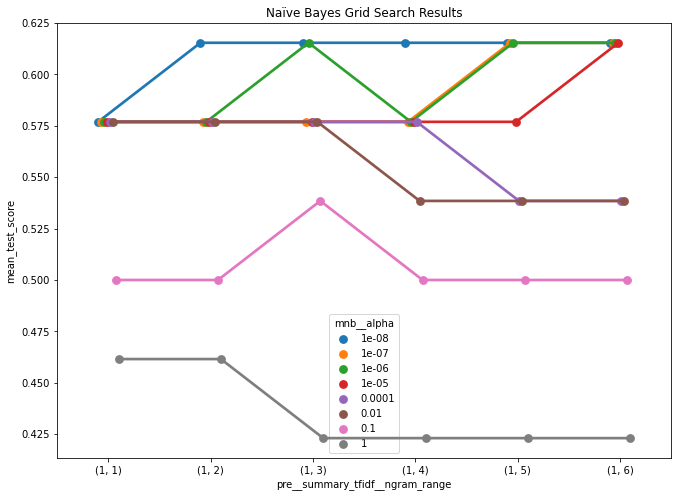

In [141]:
with open(working_path/'models/gs_mnb.pkl.gzip', 'rb') as f:
  gs_mnb = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_mnb.cv_results_, 'pre__summary_tfidf__ngram_range', 'mnb__alpha')
plt.title('Naïve Bayes Grid Search Results')
plt.show()

Forecasting

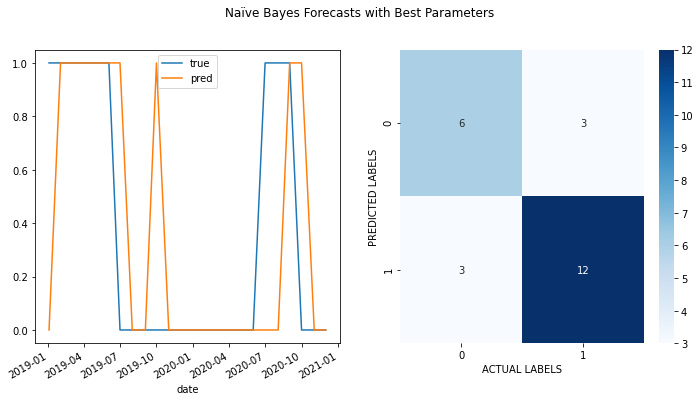

In [142]:
# Using the best hyperparameters, 
mnb_pipeline.set_params(**gs_mnb.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
mnb_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)

# fit the pipeline on data from dates(0,t-1) and predict on date(t)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  # Fit pipeline then predict
  mnb_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = mnb_pipeline.predict(X.loc[test_idx])
  mnb_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, mnb_pred, 'Naïve Bayes Forecasts with Best Parameters')

In [143]:
import model_evaluation_utils as meu
meu.get_metrics(true_labels=true, predicted_labels=mnb_pred)

Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Score: 0.75


### Logistic Regression

In [144]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([('pre', preprocessor),
                        ('lr', LogisticRegression(max_iter=100,
                                                  solver='liblinear',
                                                  class_weight='balanced'))],
                       memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'lr__penalty': ['l1', 'l2']}

In [145]:
# gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_lr = gs_lr.fit(X_gs, y_gs)

# with open(working_path/'models/gs_lr.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_lr,f)

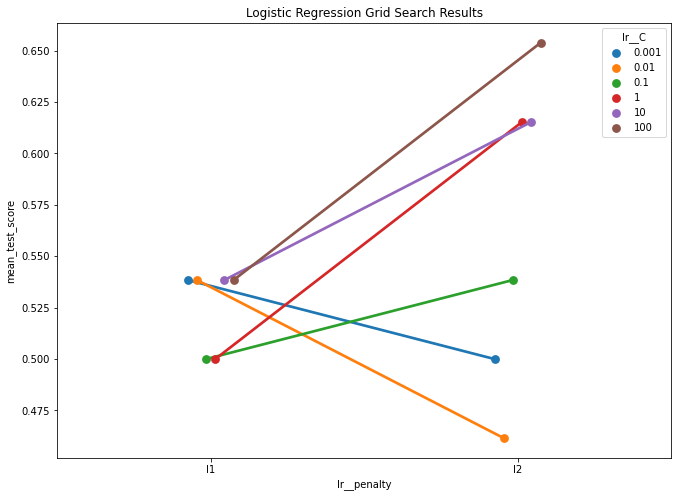

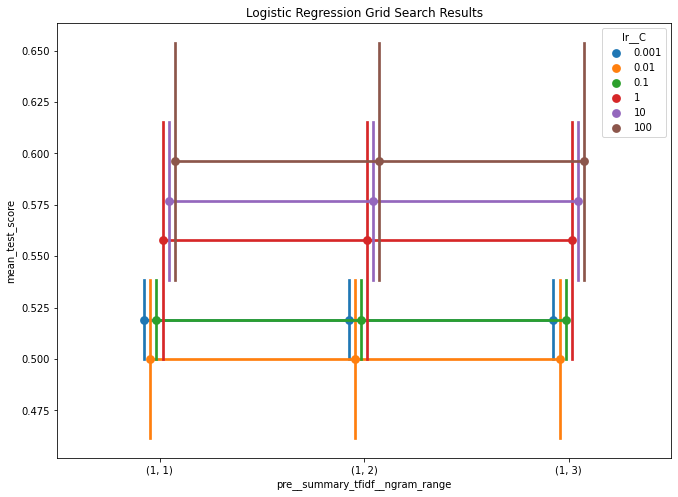

In [146]:
with open(working_path/'models/gs_lr.pkl.gzip', 'rb') as f:
  gs_lr = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_lr.cv_results_, 'lr__penalty', 'lr__C')
plt.title('Logistic Regression Grid Search Results')

fig = plot_cv_results(gs_lr.cv_results_, 'pre__summary_tfidf__ngram_range', 'lr__C')
plt.title('Logistic Regression Grid Search Results');

Forecasting

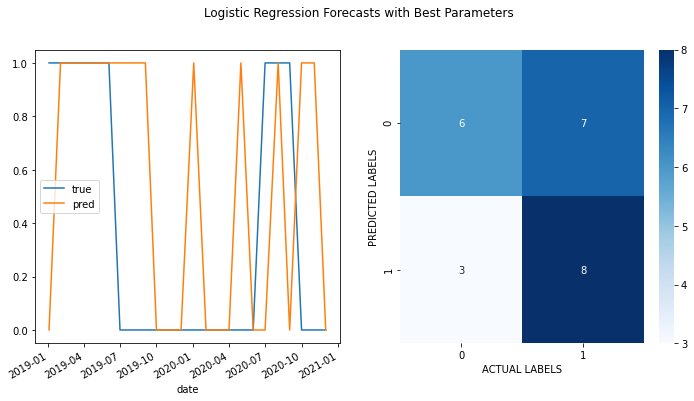

In [147]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)
lr_pipeline.set_params(**gs_lr.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
lr_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  # Fit pipeline then predict
  lr_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = lr_pipeline.predict(X.loc[test_idx])
  lr_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, lr_pred, 'Logistic Regression Forecasts with Best Parameters')

In [148]:
meu.get_metrics(true_labels=true, predicted_labels=lr_pred)

Accuracy: 0.5833
Precision: 0.6276
Recall: 0.5833
F1 Score: 0.5892


### Support Vector Machine (SVM)

In [149]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([('pre', preprocessor),
                        ('svm', LinearSVC(class_weight='balanced'))],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'svm__C': [0.01, 0.1, 1, 5]
}

In [150]:
# gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_svm = gs_svm.fit(X_gs, y_gs)

# with open(working_path/'models/gs_svm.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_svm,f)

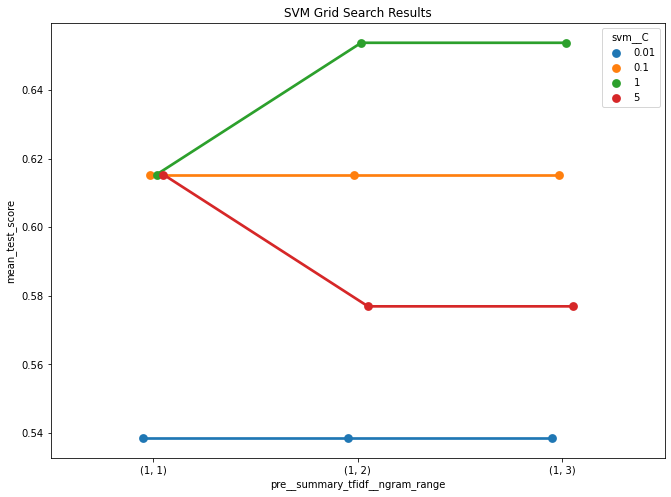

In [151]:
with open(working_path/'models/gs_svm.pkl.gzip', 'rb') as f:
  gs_svm = pickle.load(f)

fig = plot_cv_results(gs_svm.cv_results_, 'pre__summary_tfidf__ngram_range', 'svm__C')
plt.title('SVM Grid Search Results');

Forecasting

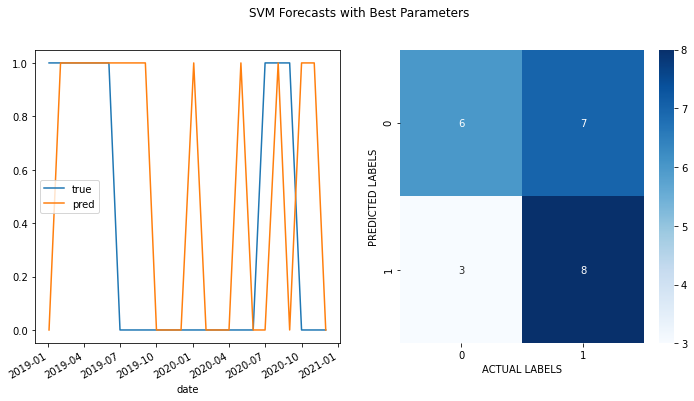

In [152]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)
svm_pipeline.set_params(**gs_svm.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
svm_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  # Fit pipeline then predict
  svm_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = svm_pipeline.predict(X.loc[test_idx])
  svm_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, svm_pred, 'SVM Forecasts with Best Parameters')

In [153]:
meu.get_metrics(true_labels=true, predicted_labels=svm_pred)

Accuracy: 0.5833
Precision: 0.6276
Recall: 0.5833
F1 Score: 0.5892


### Stochasitic Gradient Descent (SGD)

In [154]:
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline([('pre', preprocessor),
                        ('sgd', SGDClassifier(class_weight='balanced'))],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

In [155]:
# gs_sgd = GridSearchCV(sgd_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_sgd = gs_sgd.fit(X_gs, y_gs)

# with open(working_path/'models/gs_sgd.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_sgd,f)

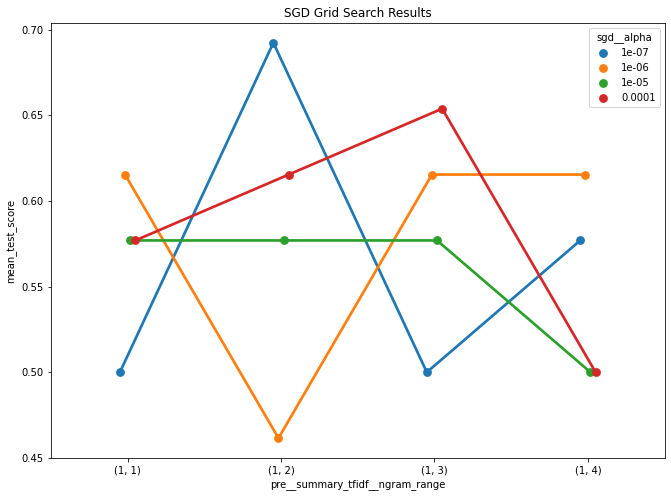

In [156]:
with open(working_path/'models/gs_sgd.pkl.gzip', 'rb') as f:
  gs_sgd = pickle.load(f)

fig = plot_cv_results(gs_sgd.cv_results_, 'pre__summary_tfidf__ngram_range', 'sgd__alpha')
plt.title('SGD Grid Search Results');

Forecasting

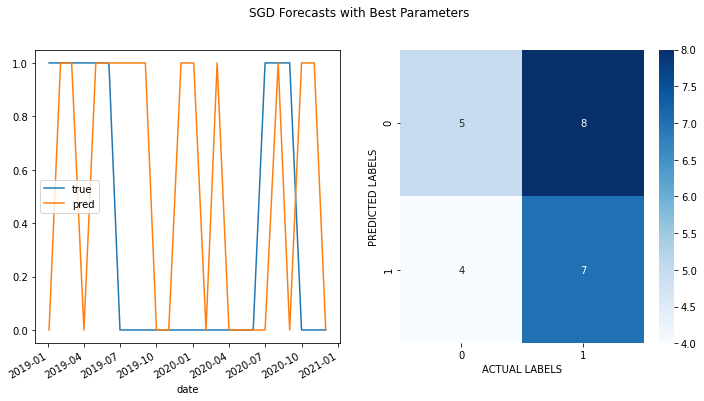

In [157]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
sgd_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  sgd_pipeline.set_params(**gs_sgd.best_params_)
  # Fit pipeline then predict
  sgd_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = sgd_pipeline.predict(X.loc[test_idx])
  sgd_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, sgd_pred, 'SGD Forecasts with Best Parameters')

In [158]:
meu.get_metrics(true_labels=true, predicted_labels=sgd_pred)

Accuracy: 0.5
Precision: 0.542
Recall: 0.5
F1 Score: 0.507


### Random Forest

In [159]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipeline = Pipeline([('pre', preprocessor),
                        ('rfc', RandomForestClassifier())],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
              'rfc__n_estimators': [10, 50, 100, 200]
}

In [160]:
# gs_rfc = GridSearchCV(rfc_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_rfc = gs_rfc.fit(X_gs, y_gs)

# with open(working_path/'models/gs_rfc.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_rfc,f)

Text(0.5, 1.0, 'Random Forest Grid Search Results')

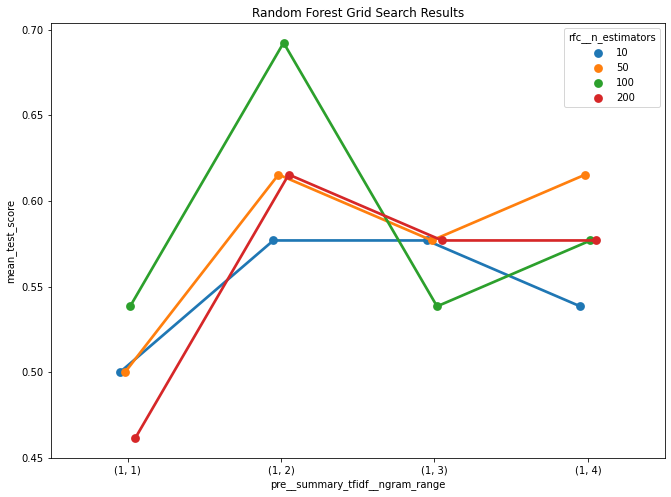

In [161]:
with open(working_path/'models/gs_rfc.pkl.gzip', 'rb') as f:
  gs_rfc = pickle.load(f)

fig = plot_cv_results(gs_rfc.cv_results_, 'pre__summary_tfidf__ngram_range', 'rfc__n_estimators')
plt.title('Random Forest Grid Search Results')

Forecasting

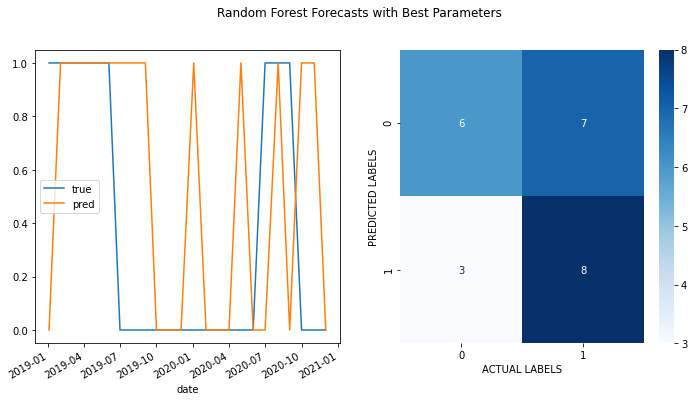

In [162]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
rfc_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  rfc_pipeline.set_params(**gs_rfc.best_params_)
  # Fit pipeline then predict
  rfc_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = rfc_pipeline.predict(X.loc[test_idx])
  rfc_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, svm_pred, 'Random Forest Forecasts with Best Parameters')

In [163]:
meu.get_metrics(true_labels=true, predicted_labels=rfc_pred)

Accuracy: 0.75
Precision: 0.7605
Recall: 0.75
F1 Score: 0.729


### Gradient Boosting Machine (GBM)

In [164]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipeline = Pipeline([('pre', preprocessor),
                        ('gbc', GradientBoostingClassifier())],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'gbc__n_estimators': [10, 50, 100, 200]}

In [165]:
# gs_gbc = GridSearchCV(gbc_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_gbc = gs_gbc.fit(X_gs, y_gs)

# with open(working_path/'models/gs_gbc.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_gbc,f)

Text(0.5, 1.0, 'Gradient Boosting Machine Grid Search Results')

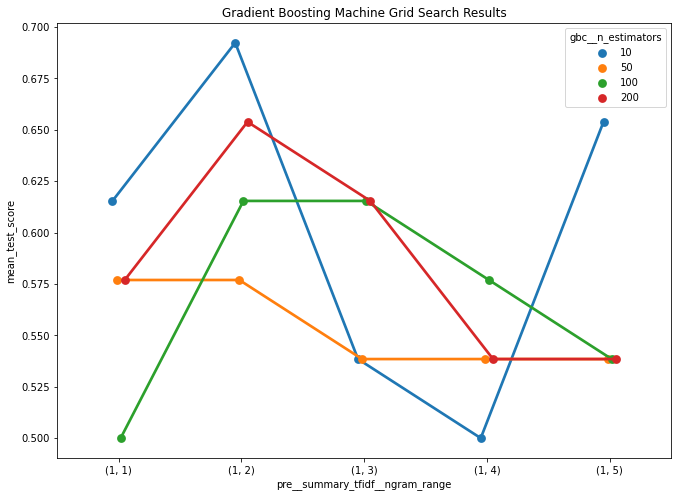

In [166]:
with open(working_path/'models/gs_gbc.pkl.gzip', 'rb') as f:
  gs_gbc = pickle.load(f)

fig = plot_cv_results(gs_gbc.cv_results_, 'pre__summary_tfidf__ngram_range', 'gbc__n_estimators')
plt.title('Gradient Boosting Machine Grid Search Results')


Forecasting

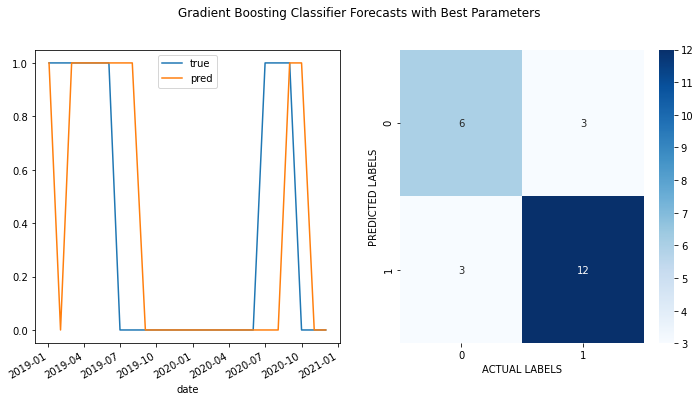

In [167]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
gbc_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  gbc_pipeline.set_params(**gs_gbc.best_params_)
  # Fit pipeline then predict
  gbc_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = gbc_pipeline.predict(X.loc[test_idx])
  gbc_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, gbc_pred, 'Gradient Boosting Classifier Forecasts with Best Parameters')

In [168]:
meu.get_metrics(true_labels=true, predicted_labels=gbc_pred)

Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Score: 0.75


### Multi-layer Perceptron (MLP)

In [169]:
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline([('pre', preprocessor),
                         ('mlp', MLPClassifier(solver='adam', 
                                               learning_rate='adaptive', 
                                               early_stopping=True,
                                               activation = 'relu', 
                                               hidden_layer_sizes=(512, 512)))],
                        memory=cachedir)

param_grid = {'pre__summary_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'mlp__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}

In [170]:
# gs_mlp = GridSearchCV(mlp_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_mlp = gs_mlp.fit(X_gs, y_gs)

# with open(working_path/'models/gs_mlp.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_mlp,f)

Text(0.5, 1.0, 'Multi-layer Perceptron  Grid Search Results')

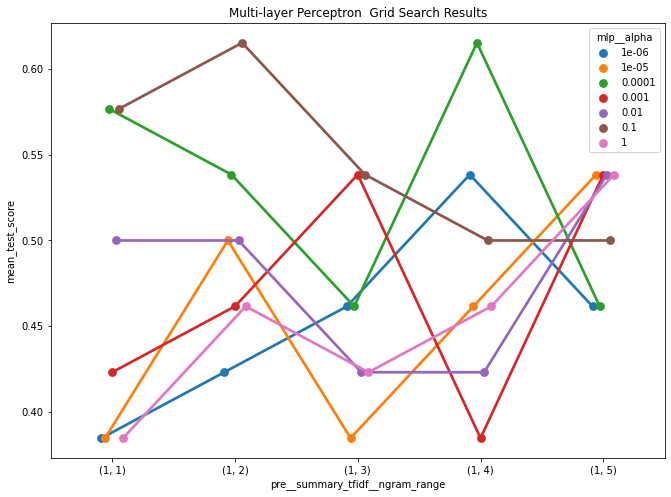

In [171]:
with open(working_path/'models/gs_mlp.pkl.gzip', 'rb') as f:
  gs_mlp = pickle.load(f)

fig = plot_cv_results(gs_mlp.cv_results_, 'pre__summary_tfidf__ngram_range', 'mlp__alpha')
plt.title('Multi-layer Perceptron  Grid Search Results')

Best parameters: {'mlp__alpha': 0.0001, 'pre__summary_tfidf__ngram_range': (1, 4)}


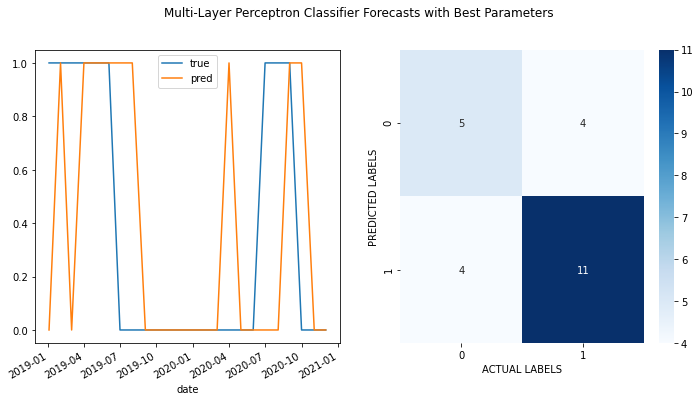

In [172]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)
print('Best parameters:', gs_mlp.best_params_)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
mlp_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  mlp_pipeline.set_params(**gs_mlp.best_params_)
  # Fit pipeline then predict
  mlp_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = mlp_pipeline.predict(X.loc[test_idx])
  mlp_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, mlp_pred, 'Multi-Layer Perceptron Classifier Forecasts with Best Parameters')

In [173]:
meu.get_metrics(true, mlp_pred)

Accuracy: 0.6667
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667


## Compare baseline models

In [174]:
baseline_models_preds = pd.DataFrame({'true': true,
                                      'mnb_pred': mnb_pred,
                                      'lr_pred': lr_pred,
                                      'svm_pred': svm_pred,
                                      'sgd_pred': sgd_pred,
                                      'rfc-pred': rfc_pred,
                                      'gbc_pred': gbc_pred,
                                      'mlp_pred': mlp_pred},
                                      index=true.index)
baseline_models_preds.tail()

,true,mnb_pred,lr_pred,svm_pred,sgd_pred,rfc-pred,gbc_pred,mlp_pred
date,,,,,,,,
2020-08-03,1,0,1,1,1,0,0,0
2020-09-01,1,1,0,0,0,0,1,1
2020-10-01,0,1,1,1,1,0,1,1
2020-11-02,0,0,1,1,1,0,0,0
2020-12-01,0,0,0,0,0,0,0,0


In [175]:
pd.DataFrame([['Naive Bayes', 
               gs_mnb.cv_results_['mean_fit_time'].mean(), 
               gs_mnb.cv_results_['mean_score_time'].mean(),
               gs_mnb.cv_results_['mean_test_score'].mean()],
              ['Logistic Regression', 
               gs_lr.cv_results_['mean_fit_time'].mean(), 
               gs_lr.cv_results_['mean_score_time'].mean(),
               gs_lr.cv_results_['mean_test_score'].mean()],
              ['Linear SVM', 
               gs_svm.cv_results_['mean_fit_time'].mean(), 
               gs_svm.cv_results_['mean_score_time'].mean(),
               gs_svm.cv_results_['mean_test_score'].mean()],
              ['Linear SVM (SGD)', 
               gs_sgd.cv_results_['mean_fit_time'].mean(), 
               gs_sgd.cv_results_['mean_score_time'].mean(),
               gs_sgd.cv_results_['mean_test_score'].mean()],
              ['Random Forest', 
               gs_rfc.cv_results_['mean_fit_time'].mean(), 
               gs_rfc.cv_results_['mean_score_time'].mean(),
               gs_rfc.cv_results_['mean_test_score'].mean()],
              ['Gradient Boosted Machines', 
               gs_gbc.cv_results_['mean_fit_time'].mean(), 
               gs_gbc.cv_results_['mean_score_time'].mean(),
               gs_gbc.cv_results_['mean_test_score'].mean()],
              ['Multi-layer Perceptron', 
               gs_mlp.cv_results_['mean_fit_time'].mean(), 
               gs_mlp.cv_results_['mean_score_time'].mean(),
               gs_mlp.cv_results_['mean_test_score'].mean()]],
             columns=['Model', 'mean_fit_time', 'mean_score_time', 'mean_test_score'],
             ).set_index('Model')

,mean_fit_time,mean_score_time,mean_test_score
Model,,,
Naive Bayes,0.098620,0.011817,0.555288
Logistic Regression,0.038904,0.010786,0.544872
Linear SVM,0.041014,0.010925,0.596154
Linear SVM (SGD),0.052838,0.011996,0.572115
Random Forest,0.188363,0.020565,0.567308
Gradient Boosted Machines,1.108305,0.011813,0.576923
Multi-layer Perceptron,2.824963,0.018737,0.483516


The SVM methods performed best, though none of the models are good.

MLP model is worst performer and almost 100 times slower to fit than the best performing model. We will exclude the MLP model from further comparisions. 

## Modelings with context-based features

In [176]:
# tokenize corpus
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()

tokenized_train = [tokenizer.tokenize(text)
                   for text in train_corpus]
tokenized_test = [tokenizer.tokenize(text)
                   for text in test_corpus]

In [177]:
def document_vectorizer(corpus, model, vector_size):
  vocabulary = set(model.wv.index_to_key)
  
  def average_word_vectors(words, model, vocabulary, vector_size):
    feature_vector = np.zeros((vector_size,), dtype="float64")
    nwords = 0.
    for word in words:
      if word in vocabulary: 
        nwords = nwords + 1.
        feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
      feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

  features = [average_word_vectors(tokenized_sentence, model, vocabulary, vector_size)
                  for tokenized_sentence in corpus]
  return np.array(features)

def normalize_document(doc, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_stemming=False, text_lemmatization=True, 
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True, stopwords=stopword_list):
  # strip HTML
  if html_stripping:
      doc = strip_html_tags(doc)
  # remove accented characters
  if accented_char_removal:
      doc = remove_accented_chars(doc)
  # expand contractions    
  if contraction_expansion:
      doc = expand_contractions(doc)
  # lowercase the text    
  if text_lower_case:
      doc = doc.lower()
  # remove extra newlines
  doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
  # lemmatize text
  if text_lemmatization:
      doc = lemmatize_text(doc)
  # remove special characters and\or digits    
  if special_char_removal:
      # insert spaces between special characters to isolate them    
      special_char_pattern = re.compile(r'([{.(-)!}])')
      doc = special_char_pattern.sub(" \\1 ", doc)
      doc = remove_special_characters(doc, remove_digits=remove_digits)  
  # remove extra whitespace
  doc = re.sub(' +', ' ', doc)
  # remove stopwords
  if stopword_removal:
      doc = remove_stopwords(doc, is_lower_case=text_lower_case)
  return doc

### Word2Vec

Gensim implements the word2vec model

In [178]:
import gensim

# build word2vec model
vector_size = 20    # Word vector dimensionality  
window = 100         # Context window size                                                                                    
min_count = 2   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_train, 
                              vector_size=vector_size, 
                              window=window, 
                              min_count=min_count,
                              sample=sample, 
                              epochs=200)


In [179]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = document_vectorizer(corpus=tokenized_train, 
                                            model=w2v_model,
                                            vector_size=vector_size)
avg_wv_test_features = document_vectorizer(corpus=tokenized_test, 
                                           model=w2v_model,
                                           vector_size=vector_size)

print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, 
      ' Test features shape:', avg_wv_test_features.shape)

Word2Vec model:> Train features shape: (69, 20)  Test features shape: (24, 20)


In [180]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

# Check a simple model
svm = SGDClassifier(loss='hinge', penalty='l2', max_iter=500)
svm.fit(avg_wv_train_features, train_labels)
svm_w2v_cv_scores = cross_val_score(svm, avg_wv_train_features, train_labels, cv=5)
svm_w2v_cv_mean_score = np.mean(svm_w2v_cv_scores)
print('CV Accuracy (5-fold):', svm_w2v_cv_scores)
print('Mean CV Accuracy:', svm_w2v_cv_mean_score)
svm_w2v_test_score = svm.score(avg_wv_test_features, test_labels)
print('Test Accuracy:', svm_w2v_test_score)

CV Accuracy (5-fold): [0.5        0.5        0.35714286 0.57142857 0.38461538]
Mean CV Accuracy: 0.46263736263736266
Test Accuracy: 0.4166666666666667


In [181]:
from sklearn.base import BaseEstimator, TransformerMixin

class TokenVectorizer(BaseEstimator, TransformerMixin):
  def __init__(self, model, vector_size):
    self.model = model
    self.vector_size = vector_size 

  def transform(self, X, *args):
    tokenized_corpus = X
    return document_vectorizer(tokenized_corpus, self.model, self.vector_size)

  def fit(self, *_):
    return self

advanced_preprocessor = ColumnTransformer(
                [("summary_vectorizer", TokenVectorizer(w2v_model, vector_size), 'clean_summary'),
                ("wras_vectorizer", TokenVectorizer(w2v_model, vector_size), 'clean_wras'),
                ('commod_names_up_cv', CountVectorizer(), 'commodities_up_in_price'),
                ('commod_names-down_cv', CountVectorizer(), 'commodities_down_in_price'),
                ('commod_names-short_cv', CountVectorizer(), 'commodities_in_short_supply'),
                ('commod_count_scaler', MinMaxScaler(), ['commodities_up_count',
                                                          'commodities_down_count',
                                                          'commodities_short_count'])])
# Visualize advanced preprocessor
advanced_preprocessor

ColumnTransformer(transformers=[('summary_vectorizer',
                                 TokenVectorizer(model=<gensim.models.word2vec.Word2Vec object at 0x7f6d63e43650>,
                                                 vector_size=20),
                                 'clean_summary'),
                                ('wras_vectorizer',
                                 TokenVectorizer(model=<gensim.models.word2vec.Word2Vec object at 0x7f6d63e43650>,
                                                 vector_size=20),
                                 'clean_wras'),
                                ('commod_names_up_cv', CountVectorizer(),
                                 'commodities_up_in_price'),
                                ('commod_names-down_cv', CountVectorizer(),
                                 'commodities_down_in_price'),
                                ('commod_names-short_cv', CountVectorizer(),
                                 'commodities_in_short_supply'),
                                ('commod_count_scaler', MinMaxScaler(),
                                 ['commodities_up_count',
                                  'commodities_down_count',
                                  'commodities_short_count'])])

#### Support Vector Machine (SVM)

In [182]:
from sklearn.svm import LinearSVC

svm_w2v_pipeline = Pipeline([('adv_pre', advanced_preprocessor),
                             ('svm', LinearSVC(class_weight='balanced', 
                                               dual=True,
                                               max_iter=2000))],
                              memory=cachedir)

param_grid = {'adv_pre__summary_vectorizer': [TokenVectorizer(w2v_model, vector_size)],
              'adv_pre__wras_vectorizer': [TokenVectorizer(w2v_model, vector_size)],
              'svm__loss': ['hinge', 'squared_hinge'],
              'svm__C': [0.01, 0.1, 1, 5]}

In [183]:
# gs_svm_w2v = GridSearchCV(svm_w2v_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_svm_w2v = gs_svm_w2v.fit(X_gs, y_gs)

# with open(working_path/'models/gs_svm_w2v.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_svm_w2v,f)

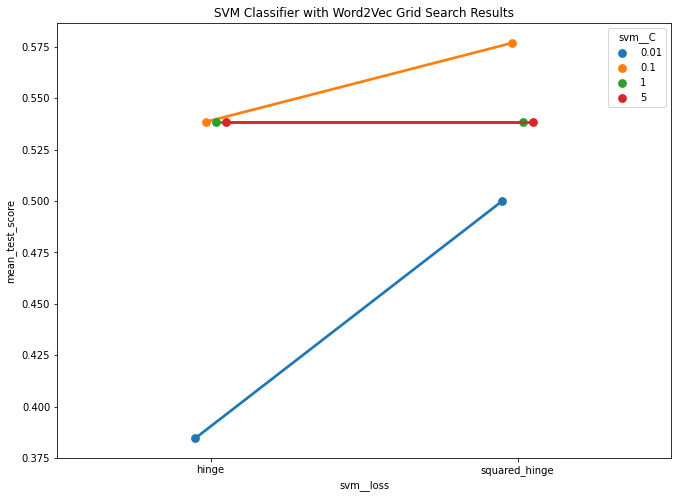

In [184]:
with open(working_path/'models/gs_svm_w2v.pkl.gzip', 'rb') as f:
  gs_svm_w2v = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_svm_w2v.cv_results_, 'svm__loss', 'svm__C')
plt.title('SVM Classifier with Word2Vec Grid Search Results');


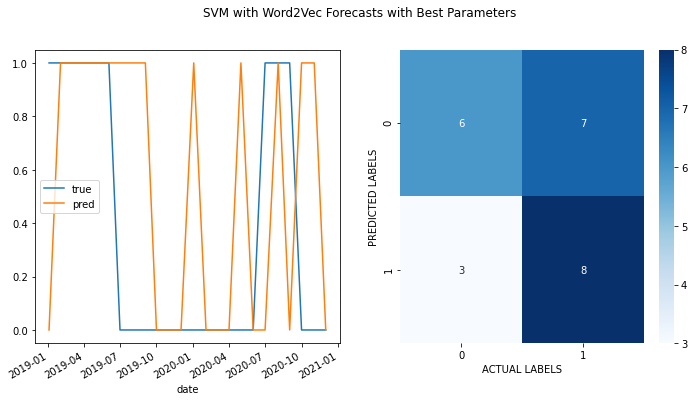

In [185]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
svm_w2v_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  svm_w2v_pipeline.set_params(**gs_svm_w2v.best_params_)
  # Fit pipeline then predict
  svm_w2v_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = svm_w2v_pipeline.predict(X.loc[test_idx])
  svm_w2v_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, svm_w2v_pred, 'SVM with Word2Vec Forecasts with Best Parameters')

In [186]:
meu.get_metrics(true, svm_w2v_pred)

Accuracy: 0.5833
Precision: 0.6276
Recall: 0.5833
F1 Score: 0.5892


#### Stochasitic Gradient Descent (SGD)

In [187]:
from sklearn.linear_model import SGDClassifier

sgd_w2v_pipeline = Pipeline([('adv_pre', advanced_preprocessor),
                             ('sgd', SGDClassifier(class_weight='balanced'))],
                            memory=cachedir)

param_grid = {'adv_pre__summary_vectorizer': [TokenVectorizer(w2v_model, vector_size)],
              'adv_pre__wras_vectorizer': [TokenVectorizer(w2v_model, vector_size)],
              'sgd__penalty': ['l1', 'l2'],
              'sgd__alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

In [188]:
# gs_sgd_w2v = GridSearchCV(sgd_w2v_pipeline, param_grid, cv=gs_splits, verbose=1)
# gs_sgd_w2v = gs_sgd_w2v.fit(X_gs, y_gs)

# with open(working_path/'models/gs_sgd_w2v.pkl.gzip', 'wb') as f:
#   pickle.dump(gs_sgd_w2v,f)

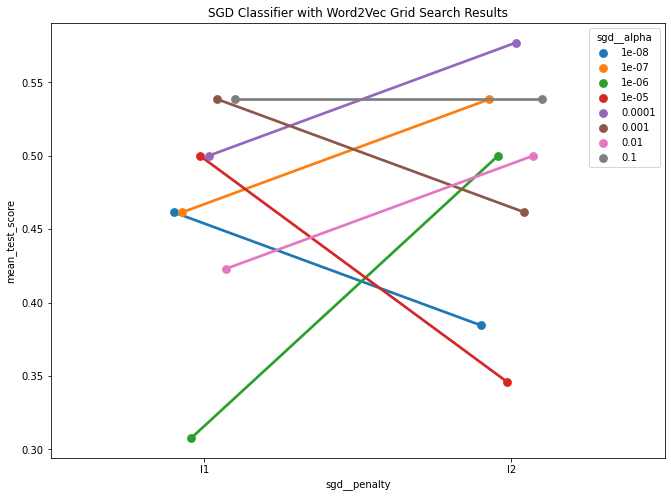

In [189]:
with open(working_path/'models/gs_sgd_w2v.pkl.gzip', 'rb') as f:
  gs_sgd_w2v = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_sgd_w2v.cv_results_, 'sgd__penalty', 'sgd__alpha')
plt.title('SGD Classifier with Word2Vec Grid Search Results');


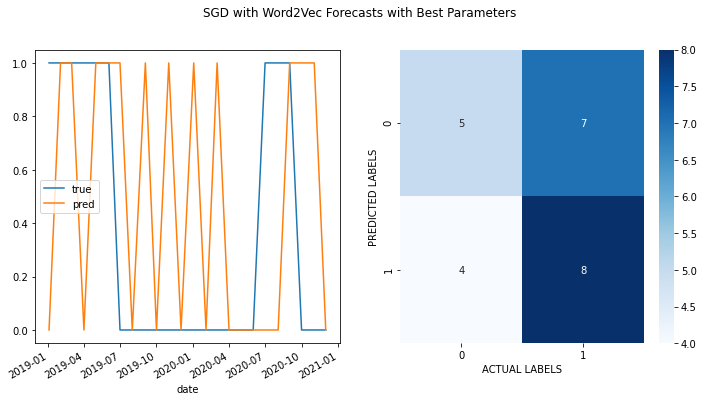

In [190]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
sgd_w2v_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  sgd_w2v_pipeline.set_params(**gs_sgd_w2v.best_params_)
  # Fit pipeline then predict
  sgd_w2v_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = sgd_w2v_pipeline.predict(X.loc[test_idx])
  sgd_w2v_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, sgd_w2v_pred, 'SGD with Word2Vec Forecasts with Best Parameters')

In [191]:
meu.get_metrics(true, sgd_w2v_pred)

Accuracy: 0.5417
Precision: 0.5729
Recall: 0.5417
F1 Score: 0.5489


### GloVe

In [192]:
# feature engineering with GloVe model
# Spacy's default embeddings use the GloVe model
train_nlp = [nlp(item) for item in train_corpus]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp(item) for item in test_corpus]
test_glove_features = np.array([item.vector for item in test_nlp])

print('GloVe model:> Train features shape:', train_glove_features.shape, 
      ' Test features shape:', test_glove_features.shape)

GloVe model:> Train features shape: (69, 300)  Test features shape: (24, 300)


In [193]:
# Check the GloVe features in a simple model
svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(train_glove_features, train_labels)
svm_glove_cv_scores = cross_val_score(svm, train_glove_features, train_labels, cv=5)
svm_glove_cv_mean_score = np.mean(svm_glove_cv_scores)
print('CV Accuracy (5-fold):', svm_glove_cv_scores)
print('Mean CV Accuracy:', svm_glove_cv_mean_score)
svm_glove_test_score = svm.score(test_glove_features, test_labels)
print('Test Accuracy:', svm_glove_test_score)

CV Accuracy (5-fold): [0.57142857 0.42857143 0.57142857 0.57142857 0.46153846]
Mean CV Accuracy: 0.5208791208791209
Test Accuracy: 0.5833333333333334


In [194]:
from sklearn.base import BaseEstimator, TransformerMixin

class GloVeVectorizor(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_core_web_md"):
        self.model = model
        self.nlp = spacy.load(self.model)

    def fit(self,X,y=None):
        return self

    def transform(self,X):
      train_nlp = [nlp(doc) for doc in X]
      train_glove_features = np.array([doc.vector for doc in train_nlp])
      return train_glove_features
        # return np.concatenate([self.nlp(doc).vector.reshape(1,-1) for doc in X])

#### Support Vector Machine (SVM)

In [195]:
from sklearn.svm import LinearSVC

svm_glove_pipeline = Pipeline([('adv_pre', advanced_preprocessor),
                               ('svm', LinearSVC(class_weight='balanced'))],
                                 memory=cachedir)

param_grid = {'adv_pre__summary_vectorizer': [GloVeVectorizor()],
              'adv_pre__wras_vectorizer': [GloVeVectorizor()],
              'svm__loss': ['hinge', 'squared_hinge'],
              'svm__C': [0.01]}

In [ ]:
gs_svm_glove = GridSearchCV(svm_glove_pipeline, param_grid, cv=gs_splits, verbose=1)
gs_svm_glove = gs_svm_glove.fit(X_gs, y_gs)

with open(working_path/'models/gs_svm_glove.pkl.gzip', 'wb') as f:
  pickle.dump(gs_svm_glove,f)

Fitting 13 folds for each of 2 candidates, totalling 26 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:307: UserWarning: Persisting input arguments took 17.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:307: UserWarning: Persisting input arguments took 16.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/usr/local/lib/python3

In [ ]:
with open(working_path/'models/gs_svm_glove.pkl.gzip', 'rb') as f:
  gs_svm_glove = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_svm_glove.cv_results_, 'svm__loss', 'svm__C')
plt.title('SVM Classifier with GloVe Grid Search Results');


In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
svm_glove_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  svm_glove_pipeline.set_params(**gs_svm_glove.best_params_)
  # Fit pipeline then predict
  svm_glove_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = svm_glove_pipeline.predict(X.loc[test_idx])
  svm_glove_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, svm_glove_pred, 'SVM with GloVe Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true, svm_glove_pred)

#### Stochasitic Gradient Descent (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_glove_pipeline = Pipeline([('adv_pre', advanced_preprocessor),
                               ('sgd', SGDClassifier(class_weight='balanced'))],
                                memory=cachedir)

param_grid = {'adv_pre__summary_vectorizer': [nlp],
              'adv_pre__wras_vectorizer': [nlp],
              'sgd__penalty': ['l1', 'l2'],
              'sgd__alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

gs_sgd_glove = GridSearchCV(sgd_glove_pipeline, param_grid, cv=gs_splits, verbose=1)
gs_sgd_glove = gs_sgd_glove.fit(X_gs, y_gs)

with open(working_path/'models/gs_sgd_glove.pkl.gzip', 'wb') as f:
  pickle.dump(gs_sgd_glove,f)

In [ ]:
with open(working_path/'models/gs_sgd_glove.pkl.gzip', 'rb') as f:
  gs_sgd_glove = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_sgd_glove.cv_results_, 'sgd__penalty', 'sgd__alpha')
plt.title('SGD Classifier with GloVe Grid Search Results');


In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
sgd_glove_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  sgd_glove_pipeline.set_params(**gs_sgd_glove.best_params_)
  # Fit pipeline then predict
  sgd_glove_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = sgd_glove_pipeline.predict(X.loc[test_idx])
  sgd_glove_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, sgd_glove_pred, 'SGD with GloVe Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true, sgd_glove_pred)

### FastText

In [ ]:
from gensim.models.fasttext import FastText

# Initialize the fasttext object

ft_num_features = 500
# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_train, size=ft_num_features, window=100, 
                    min_count=2, sample=1e-3, sg=1, iter=5, workers=10)

In [ ]:
# generate averaged word vector features from word2vec model
avg_ft_train_features = document_vectorizer(corpus=tokenized_train, model=ft_model,
                                                     num_features=ft_num_features)
avg_ft_test_features = document_vectorizer(corpus=tokenized_test, model=ft_model,
                                                    num_features=ft_num_features)

print('FastText model:> Train features shape:', avg_ft_train_features.shape, 
      ' Test features shape:', avg_ft_test_features.shape)

In [ ]:


svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(avg_ft_train_features, train_label_names)
svm_ft_cv_scores = cross_val_score(svm, avg_ft_train_features, train_label_names, cv=5)
svm_ft_cv_mean_score = np.mean(svm_ft_cv_scores)
print('CV Accuracy (5-fold):', svm_ft_cv_scores)
print('Mean CV Accuracy:', svm_ft_cv_mean_score)
svm_ft_test_score = svm.score(avg_ft_test_features, test_label_names)
print('Test Accuracy:', svm_ft_test_score)



In [ ]:
# feature engineering with GloVe model
# Spacy's default embeddings use the GloVe model
train_nlp = [nlp(item) for item in train_corpus]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp(item) for item in test_corpus]
test_glove_features = np.array([item.vector for item in test_nlp])

print('GloVe model:> Train features shape:', train_glove_features.shape, 
      ' Test features shape:', test_glove_features.shape)

In [ ]:
# Check the GloVe features in a simple model
svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(train_glove_features, train_labels)
svm_glove_cv_scores = cross_val_score(svm, train_glove_features, train_labels, cv=5)
svm_glove_cv_mean_score = np.mean(svm_glove_cv_scores)
print('CV Accuracy (5-fold):', svm_glove_cv_scores)
print('Mean CV Accuracy:', svm_glove_cv_mean_score)
svm_glove_test_score = svm.score(test_glove_features, test_labels)
print('Test Accuracy:', svm_glove_test_score)

#### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import LinearSVC

svm_glove_pipeline = Pipeline([('adv_pre', advanced_preprocessor),
                               ('svm', LinearSVC(class_weight='balanced', 
                                               dual=True,
                                               max_iter=1000))],
                                 memory=cachedir)

param_grid = {'adv_pre__summary_vectorizer': [nlp],
              'adv_pre__wras_vectorizer': [nlp],
              'svm__loss': ['hinge', 'squared_hinge'],
              'svm__C': [0.01, 0.1, 1, 5]}

In [ ]:
gs_svm_glove = GridSearchCV(svm_glove_pipeline, param_grid, cv=gs_splits, verbose=1)
gs_svm_glove = gs_svm_glove.fit(X_gs, y_gs)

with open(working_path/'models/gs_svm_glove.pkl.gzip', 'wb') as f:
  pickle.dump(gs_svm_glove,f)

In [ ]:
with open(working_path/'models/gs_svm_glove.pkl.gzip', 'rb') as f:
  gs_svm_glove = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_svm_glove.cv_results_, 'svm__loss', 'svm__C')
plt.title('SVM Classifier with GloVe Grid Search Results');


In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
svm_glove_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  svm_glove_pipeline.set_params(**gs_svm_glove.best_params_)
  # Fit pipeline then predict
  svm_glove_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = svm_glove_pipeline.predict(X.loc[test_idx])
  svm_glove_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, svm_glove_pred, 'SVM with GloVe Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true, svm_glove_pred)

#### Stochasitic Gradient Descent (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_glove_pipeline = Pipeline([('adv_pre', advanced_preprocessor),
                               ('sgd', SGDClassifier(class_weight='balanced'))],
                                memory=cachedir)

param_grid = {'adv_pre__summary_vectorizer': [nlp],
              'adv_pre__wras_vectorizer': [nlp],
              'sgd__penalty': ['l1', 'l2'],
              'sgd__alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

gs_sgd_glove = GridSearchCV(sgd_glove_pipeline, param_grid, cv=gs_splits, verbose=1)
gs_sgd_glove = gs_sgd_glove.fit(X_gs, y_gs)

with open(working_path/'models/gs_sgd_glove.pkl.gzip', 'wb') as f:
  pickle.dump(gs_sgd_glove,f)

In [ ]:
with open(working_path/'models/gs_sgd_glove.pkl.gzip', 'rb') as f:
  gs_sgd_glove = pickle.load(f)

# Plot grid search results
fig = plot_cv_results(gs_sgd_glove.cv_results_, 'sgd__penalty', 'sgd__alpha')
plt.title('SGD Classifier with GloVe Grid Search Results');


In [ ]:
# Using the best hyperparameters, 
# fit the pipeline on data from dates(0,t-1) and predict on date(t)

true = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
sgd_glove_pred = pd.Series(index=y.index[-len(test_corpus):], dtype=int)
for train_ilocs, test_iloc in forecast_splits.split(X):
  #map ilocs to loc
  train_idxs = X.iloc[train_ilocs].index
  test_idx = y.iloc[test_iloc].index
  sgd_glove_pipeline.set_params(**gs_sgd_glove.best_params_)
  # Fit pipeline then predict
  sgd_glove_pipeline.fit(X.loc[train_idxs], y.loc[train_idxs])
  forecast = sgd_glove_pipeline.predict(X.loc[test_idx])
  sgd_glove_pred.loc[test_idx] = forecast.item()
  true.loc[test_idx] = int(y[test_idx])

plot_forecasts(true, sgd_glove_pred, 'SGD with GloVe Forecasts with Best Parameters')

In [ ]:
meu.get_metrics(true, sgd_glove_pred)

# Further Work

* Add rolling windows to the preprocessing pipeline. Curretly, the pipeline only ue the most recent data when predicting the gdp_growth_direction. It may be useful for the models if they could learning from the vectors from previous periods.